# Predicting Pita Bread Sales at Family Bakery to Improve Orders Accuracy

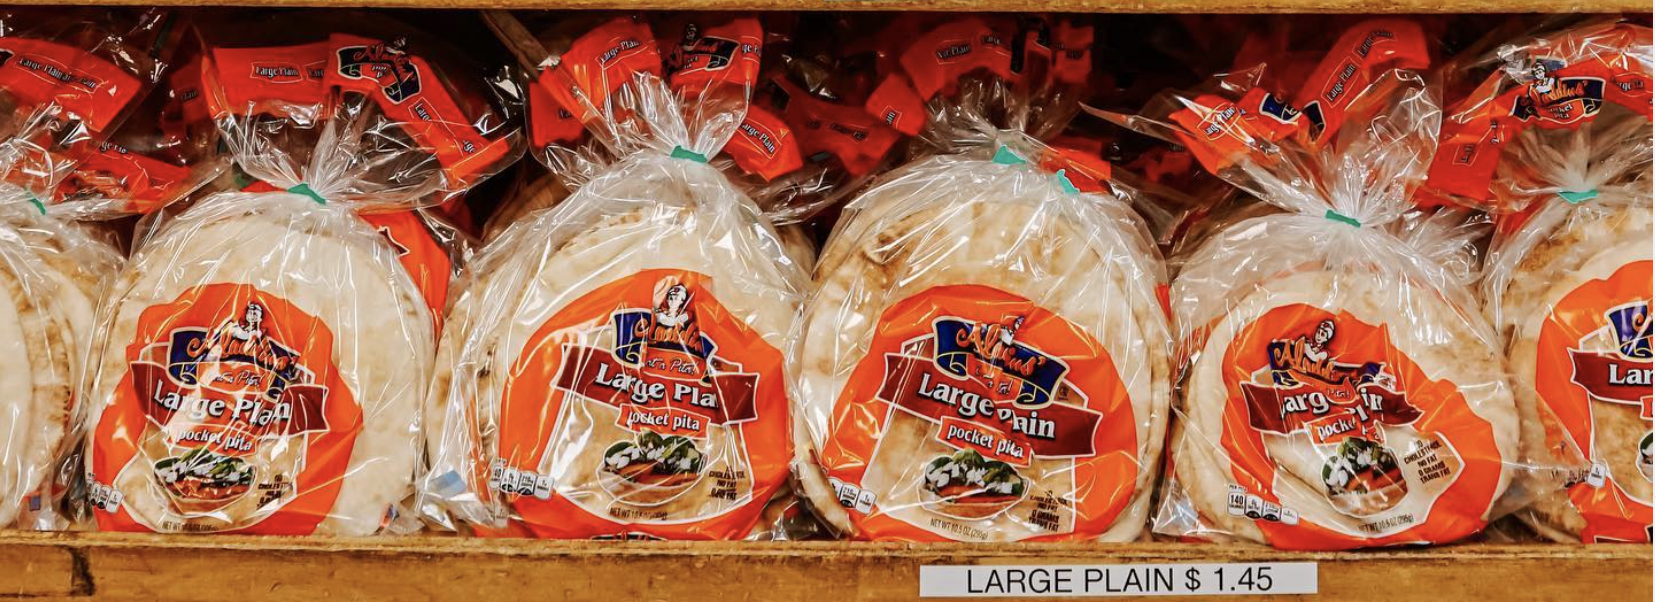

### by John Nahra

# Overview

My grandfather started a bakery in downtown Cleveland with his brother and his cousin over 50 years ago. They built up the business to be very successful and a Cleveland staple. It is a source of family pride, appreciation for my Lebanese roots, and delicious Mediterranean food!

The business has now passed onto the sons, my dad and his cousins, and is continuing to thrive. Still, businesses always have room for improvement. In talking with my dad, he identified a project centered around inventory management as a useful enterprise. In particular, the inventory management of pita bread in the store front. As the grandson of one of Aladdin's founders and its first data scientist, I jumped at the opportunity to help my family in a real-world capstone project.

The large majority of the business is baking pita bread that is then distributed to grocery stores. However, we also sell pita bread out of the store front, both to retail and wholesale customers. The store manager places bread orders five times per week for fresh bread to be baked and sold at the store the next day (or two). In its current state without using data, orders are more feel-driven. 

The impetus behind the project is to see if we can use data to better match orders to sales, thereby reducing the amount of bread that must be discounted as day old bread or discarded while at the same time ordering enough such that all who want delicious fresh pita bread are able to buy it.

There are several types of bread ordered, baked, and sold each day, but for the purposes of this project I focused only on one bread type: large plain pita bread.

Using daily data on store front transactions from January 2021 to March 2023, I was able to run a time series model to predict daily bread sales. I compared my sales predictions with the store front's bread orders over that same time frame and found that my predictions reduced the daily average order error by 25 and 33 packages of pita as compared with current orders on the train and test sets, respectively.

My 2023 sales forecast can be found in ['data/future_forecast.csv'](http://localhost:8888/edit/data/future_forecast.csv).

# Data Understanding

As mentioned above, I used daily data on store front transactions from January 2021 to March 2023. The data contained characteristics of each individual customer purchase: date, item, quantity, price, etc. 

I filtered for large plain pita bread sales only. I split those sales into retail and wholesale categories and modeled each category separately. 

Retail represents regular foot traffic. In the case of large plain pita, retail also represents customers who buy sandwiches, since large plain is used to make our shawarma wraps. Each package of pita contains five pieces of pita, thus five sandwiches is equivalent to one package of pita. 

Wholesale represents some of our wholesale customers who walk into the store front to buy bread. Generally, customers wanting more than 3 trays of bread (18 packages per tray, so 54 packages of pita) need to order ahead of time. Thus, I assumed in my model that any sale over 54 packages of pita would be known ahead of time. Most of these customers are wholesale customers, but there were a few retail customers who bought a large amount of bread as well.

For a baseline comparison, I utilized daily data on the store front's bread orders from January 2021 to March 2023. This data contained order characteristics such as date, customer ID, bread type, quantity, sale cost, etc.

For my more complex time series model with additional regressors, I added variables for Cleveland Guardians day home games and Cleveland weather features.

Aladdin's Baking Company is only a short walk from Progressive Field, the home of Cleveland's MLB franchise, so I wanted to see if pita sales were affected on days where the Guardians had a home game during the day time (defined as a game starting before 7 pm). It serves to reason that there may be some effect when there is greater foot traffic downtown (at least for sandwiches), though it could also dissuade would-be non-game-going customers from making the trip due to increased traffic. I utilized data from Baseball Reference to put together the Guardians home schedule from 2021-2023 (including playoffs), filtered for day games, and used game attendance as the variable. More fans, more traffic.

I also wanted to see if Cleveland weather could provide a more accurate, granular sales forecast outside of general annual seasonality. I gathered daily weather data from the National Oceanic and Atmospheric Administration for Cleveland Hopkins Airport, which is about 15 minutes away from the bakery. I was able to get features such as precipitation and snowfall in inches as well as maximum temperature for each day.

# Data Preparation

In [1]:
#imports necessary starter Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#reads in the transactions data
df = pd.read_csv('data/transaction items.csv')

In [3]:
#takes a peak at the transactions data
#df.head()

In [4]:
#creates a new dataframe that includes only wholesale large plain pita sales
df_ws = df.loc[df['Line Item'] == 'Alad. Large Plain WS']

In [5]:
#creates a new dataframe that includes only retail large plain pita sales and pita sandwiches
df = df.loc[(df["Line Item"] == 'Alad. Large Plain') | (df['Line Item'] == 'Lunch box special') | (df['Category'] == 'Stuffed Pita Sandwiches')]

In [6]:
#defines a function that takes in a dataframe and returns the number of pita packages sold in a transaction
#each package of pita sold is equivalent to 1 package of pita, while each sandwich is sold is 1/5 of a package of pita
#since there are 5 pitas in a package
def pita_package_count(row):
    if row['Category'] == 'Stuffed Pita Sandwiches' or row['Line Item'] == 'Lunch box special':
        return row['Quantity']/5
    else:
        return row['Quantity']

In [7]:
#create new column that applies the function to retail and wholesale dataframes
df['pita count'] = df.apply(pita_package_count,axis=1)

df_ws['pita count'] = df_ws.apply(pita_package_count,axis=1)

In [8]:
#check to see column was successfully created
#df.head(10)

I noticed that there were various unit costs based on quantity and price. I wanted to investigate to make sure there weren't any purchases being incorrectly classified as retail or wholesale. There was generally a few top unit costs by value counts, which makes sense. Generally one price that may have changed twice as costs went up the last couple years. There was more variability in unit cost than I would like, but there could be different unit costs for different customers and based on quantity bought. I also noticed some unit costs were negative, representing returns.

In [9]:
#defines a function that calculates the unit cost of a package of pita
def unit_cost(row):
    if row['Category'] == 'Stuffed Pita Sandwiches' or row['Line Item'] == 'Lunch box special':
        return 0
    else:
        return round(row['Total Due']/row['Quantity'],2)

#create a new column that applies that function to retail and wholesale dataframes
df['unit cost'] = df.apply(unit_cost,axis=1)

df_ws['unit cost'] = df_ws.apply(unit_cost,axis=1)

In [10]:
#looks at retail unit cost value counts
#df['unit cost'].value_counts()

In [11]:
#looks at wholesale unit cost value counts
#df_ws['unit cost'].value_counts()

In [12]:
#checks out wholesale negative unit cost transaction
df_ws.loc[df_ws['unit cost'] == -1.32]

Time Register Name/Number Cashier Name Operation Type  \
105321  08/27/2022 02:26 PM           Register 2    Dominic A         RETURN   

           Store Code UPC             Line Item Department Category  \
105321  *400000000251   *  Alad. Large Plain WS  WholeSale    Bread   

           Supplier  ...  Modifiers  Subtotal  Discounts  Net Total  Tax  \
105321  not tracked  ...        0.0      -6.6        0.0       -6.6  0.0   

        Total Due                        Transaction ID  Customer ID  \
105321       -6.6  D6F0F52D-9A68-42A6-B4A0-CD074D783A75     54861335   

        pita count  unit cost  
105321         5.0      -1.32  

[1 rows x 24 columns]

In [13]:
#creates copies of retail and wholesale dataframes
df_all = df.copy()

df_all_ws = df_ws.copy()

In [14]:
#creates new datetime column in both dataframes
df_all['date'] = pd.to_datetime(df_all['Time'])

df_all_ws['date'] = pd.to_datetime(df_all_ws['Time'])

In [15]:
#sets datetime column as the index for both dataframes
df_all.set_index('date',inplace=True)

df_all_ws.set_index('date',inplace=True)

In [16]:
#creates new series for retail and wholesale that aggregates daily pita packages used
df_all_daily = df_all['pita count'].resample('D').sum()

df_all_ws_daily = df_all_ws['pita count'].resample('D').sum()

In [17]:
#creates new dataframe with both retail and wholesale daily sales
total_sales_plus = df_all_daily.to_frame().merge(df_all_ws_daily.to_frame(),left_index=True,right_index=True)

In [18]:
#renames columns to identify retail and wholesale pita sales
total_sales_plus = total_sales_plus.rename({'pita count_x': 'retail_sales','pita count_y':'wholesale_sales'},axis=1)

In [19]:
#creates new column for total sales (retail + wholesale)
total_sales_plus['total_sales'] = total_sales_plus['retail_sales'] + total_sales_plus['wholesale_sales']

In [20]:
#checks to see column was successfully created
#total_sales_plus.head()

In [21]:
#saves sales dataframe as a .csv
total_sales_plus.to_csv('data/total_large_white_plain_sales_plus.csv')

In [22]:
#limits retail and wholesale dataframes to transactions equal to or under 54 packages of pita
df = df.loc[df['pita count']<=54]

df_ws = df_ws.loc[df_ws['pita count']<=54]

In [23]:
#checks dataframe columns, data types, non-null counts
#df.info()

In [24]:
#creates new datetime column
df['date'] = pd.to_datetime(df['Time'])

df_ws['date'] = pd.to_datetime(df_ws['Time'])

In [25]:
#sets datetime column as index
df.set_index('date',inplace=True)

df_ws.set_index('date',inplace=True)

In [26]:
#creates new series that aggregates individual transactions into daily sales
df_daily = df['pita count'].resample('D').sum()

df_ws_daily = df_ws['pita count'].resample('D').sum()

In [27]:
#saves retail and wholesale daily sales excluding large sales to .csv
df_daily.to_csv('data/large_white_plain_sales.csv')

df_ws_daily.to_csv('data/large_white_plain_ws_sales.csv')

In [28]:
#combines two series into a dataframe
total_sales = df_daily.to_frame().merge(df_ws_daily.to_frame(),left_index=True,right_index=True)

In [29]:
#checks to see new total sales dataframe was created
#total_sales.head()

In [30]:
#renames pita count columns to be retail and wholesale sales
total_sales = total_sales.rename({'pita count_x': 'retail_sales','pita count_y':'wholesale_sales'},axis=1)

In [31]:
#creates new column total sales that adds retail and wholesale sales together
total_sales['total_sales'] = total_sales['retail_sales'] + total_sales['wholesale_sales']

In [32]:
#checks to see columns was successfully created
#total_sales.head()

In [33]:
#saves total sales dataframe to .csv
total_sales.to_csv('data/total_large_white_plain_sales.csv')

In [34]:
#takes a look at daily retail sales series (excluding large sales)
#df_daily.head()

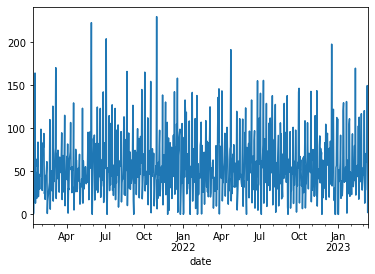

In [35]:
#plots daily retail sales
df_daily.plot();

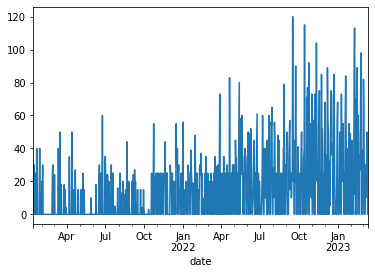

In [36]:
#plots daily wholesale sales (excluding large sales)
df_ws_daily.plot();

In [37]:
#creates datetime index from 2021-2023
index = pd.date_range(start='1/1/2021',end='12/31/2023')

In [38]:
#checks to see index was successfully created
#index

In [39]:
#reindexes daily retail and wholesale sales series
df_daily = df_daily.reindex(index)

df_ws_daily = df_ws_daily.reindex(index)

In [40]:
#checks to see retail series was reindexed
#df_daily.head()

In [41]:
#looks at top 10 retail sales days
#df_daily.sort_values(ascending=False)[:10]

In [42]:
#gets retail sales descriptive statistics
#df_daily.describe()

In [43]:
#looks at top 10 wholesale sales days
#df_ws_daily.sort_values(ascending=False)[:10]

In [44]:
#gets wholesale sales descriptive statistics
#df_ws_daily.describe()

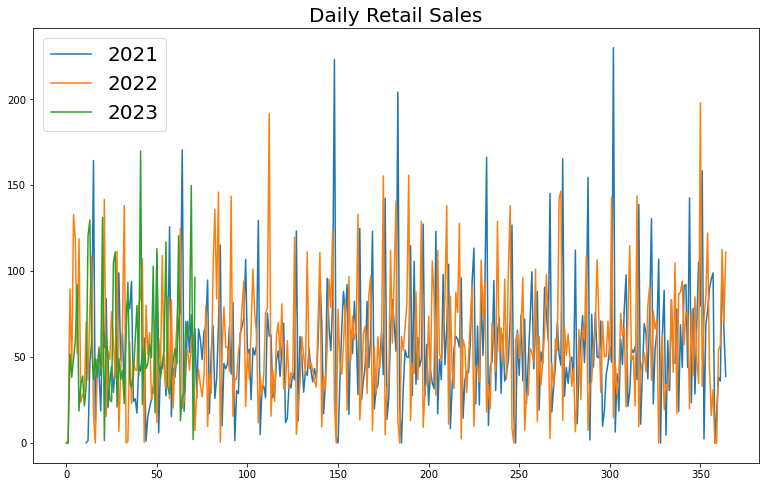

In [45]:
#creates chart of daily retail sales by year
year_groups = df_daily.groupby(pd.Grouper(freq='A'))
pita_annual = pd.DataFrame()
for yr,group in year_groups:
    pita_annual[yr.year] = group.values.ravel()
pita_annual.plot(figsize=(13,8),subplots=False,legend=True)
plt.legend(fontsize=20)
plt.title('Daily Retail Sales',fontsize=20)
plt.savefig('illustrations/daily_retail_sales.jpg',bbox_inches='tight');

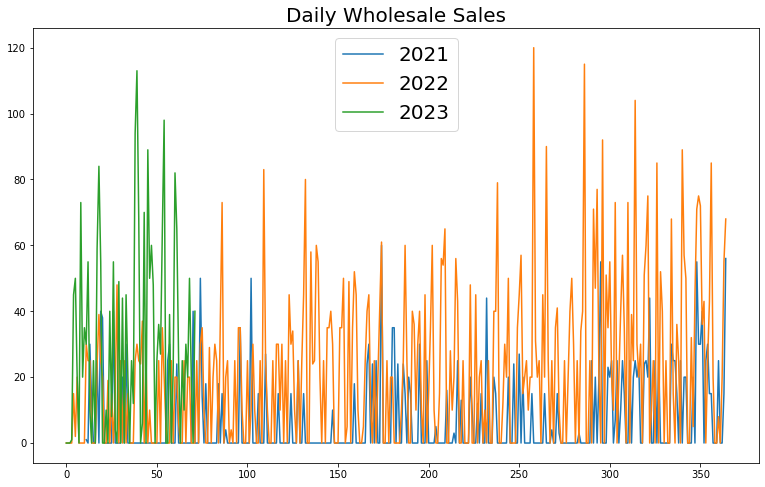

In [46]:
#creates chart of daily wholesale sales by year
year_groups = df_ws_daily.groupby(pd.Grouper(freq='A'))
pita_annual = pd.DataFrame()
for yr,group in year_groups:
    pita_annual[yr.year] = group.values.ravel()
pita_annual.plot(figsize=(13,8),subplots=False,legend=True)
plt.legend(fontsize=20)
plt.title('Daily Wholesale Sales',fontsize=20)
plt.savefig('illustrations/daily_ws_sales.jpg',bbox_inches='tight');

In [47]:
#creates new series of retail and wholesale sales that drop missing values
df_daily_na = df_daily.dropna()

df_ws_daily_na = df_ws_daily.dropna()

## Additional Regressors Data Preparation

### Guardians Day Home Games

In [48]:
#reads in Cleveland Guardians 2021 schedule from Baseball Reference
df_2021 = pd.read_csv('data/guards2021.csv',header=1)

In [49]:
#looks at first five rows of dataframe
#df_2021.head()

In [50]:
#reads in Guardians 2022 schedule data
df_2022 = pd.read_csv('data/guards2022.csv',header=1)

In [51]:
#looks at first five rows of 2022 dataframe
#df_2022.head()

In [52]:
#reads in Guardians 2023 home schedule data
df_2023 = pd.read_csv('data/guards2023.csv')

In [53]:
#looks at first five rows of 2023 data
#df_2023.head()

In [54]:
#looks at various game start times
#df_2023['START TIME ET'].value_counts()

In [55]:
#filters data to only include home games played in Cleveland (exclude spring training games in Arizona)
df_2023 = df_2023.loc[df_2023['LOCATION'] == 'Progressive Field - Cleveland']

In [56]:
#looks again at Cleveland home game start times
#df_2023['START TIME ET'].value_counts()

In [57]:
#filters data to only include day games (start times before 7 pm)
df_2023 = df_2023[~df_2023['START TIME ET'].isin(['07:10 PM','07:15 PM'])]

In [58]:
#checks to see night games were successfully excluded
#df_2023['START TIME ET'].value_counts()

In [59]:
#renames start date column to date
df_2023 = df_2023.rename({'START DATE':'Date'},axis=1)

In [60]:
#turns date column into a datetime column
df_2023['Date'] = pd.to_datetime(df_2023['Date'])

In [61]:
#sets datetime column as index
df_2023.set_index('Date',inplace=True)

In [62]:
#creates new column day that has day of the week names
df_2023['day'] = df_2023.index.day_name()

In [63]:
#checks to see columns was successfully created
#df_2023.head()

In [64]:
#takes another look at 2021 data
#df_2021.head()

In [65]:
#renames unnamed column to home for both 2021 and 2022 data
df_2021 = df_2021.rename({'Unnamed: 5': 'home'},axis=1)

df_2022 = df_2022.rename({'Unnamed: 5': 'home'},axis=1)

In [66]:
#checks to see column successfully renamed
#df_2021.head()

In [67]:
#filters for just the date and attendance columns for all home day games in 2021 and 2022
df_2021 = df_2021[['Date','Attendance']].loc[(df_2021['home'] != '@') & (df_2021['D/N'] == 'D')]

df_2022 = df_2022[['Date','Attendance']].loc[(df_2022['home'] != '@') & (df_2022['D/N'] == 'D')]

In [68]:
#takes a look at the 2021 home day game data
#df_2021

In [69]:
#takes a look at the 2022 home day game data
#df_2022

In [70]:
#figures out how to grab day of week from date column
df_2021['Date'].iloc[0].split()[0]

'Monday'

In [71]:
#defines function that takes in a dataframe and day of the week and calculates the average attendance for that day
from statistics import mean
def attendance_filler(df, day):
    attendance = []
    for i in range(0,len(df)):
        if df['Date'].iloc[i].split()[0] == day:
            attendance.append(df['Attendance'].iloc[i])
    if len(attendance) > 0:
        return sum(attendance)/len(attendance)
    else:
        return 'N/A'

In [72]:
#applies above function
#to create a dictionary for day of the week and 2021 average attendance for that day (if applicable)
week = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
dict_2021 = {}
for day in week:
    dict_2021[day] = attendance_filler(df_2021.dropna(),day)
#dict_2021

In [73]:
#applies above function
#to create a dictionary for day of the week and 2022 average attendance for that day (if applicable)
#sets value for average Friday attendance that appeared reasonable for a weekday/weekend type game
dict_2022 = {}
for day in week:
    dict_2022[day] = attendance_filler(df_2022.dropna(),day)
dict_2022['Friday'] = 17000
#dict_2022

In [74]:
#creates new column attendance for 2023 home day games based on average 2022 attendance
df_2023['Attendance'] = df_2023['day'].map(dict_2022)

In [75]:
#checks to see column was successfully created
#df_2023.head()

In [76]:
#filters dataframe to only include attendance column
df_2023 = pd.DataFrame(df_2023['Attendance'])

In [77]:
#looks at filtered dataframe
#df_2023

In [78]:
#creates new dataframes for missing attendance games in 2021 and 2022
missing_2021 = df_2021['Date'].loc[df_2021['Attendance'].isna()]

missing_2022 = df_2022['Date'].loc[df_2022['Attendance'].isna()]

In [79]:
#looks at games missing attendance in 2021
#notes that they are all game 1 of a doubleheader
#missing_2021

In [80]:
#looks at games missing attendance in 2022
#notes that they are all game 1 of a doubleheader
#missing_2022

In [81]:
#creates for loop that fills in missing 2021 attendance values with average attendance for that day of the week
for date in missing_2021:
    for i in range(0,len(df_2021)):
        if df_2021['Date'].iloc[i] == date:
            df_2021['Attendance'].iloc[i] = attendance_filler(df_2021.dropna(),date.split()[0])

/Users/johnnahra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/johnnahra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/johnnahra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [82]:
#drops rows with missing values in 2022 dataframe
#since all missing attendance games for 2022 were game 1 of a doubleheader and all game 2's had attendance data,
#it was determined that the game 1 rows were not needed and could be dropped
df_2022 = df_2022.dropna()

In [83]:
#drops row in 49th index position (Sunday May 30, 2021) because game 2 of that doubleheader had attendance data
df_2021 = df_2021.drop(49)

In [84]:
#checks to see 2021 attendance data changes were made
#df_2021

In [85]:
#checks to see 2022 attendance data changes were made
#df_2022

In [86]:
#resets index for both years
df_2021 = df_2021.reset_index(drop=True)

df_2022 = df_2022.reset_index(drop=True)

In [87]:
#checks to see index was reset
#df_2021

In [88]:
#writes for loop to remove parentheses denoting game 1 or 2 of doubleheader from 2021 date column
for i in range(0,len(df_2021)):
    if '(' in df_2021['Date'].iloc[i]:
        df_2021['Date'].iloc[i] = df_2021['Date'].iloc[i][:-4]

/Users/johnnahra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [89]:
#writes for loop to remove parentheses denoting game 1 or 2 of doubleheader from 2022 date column
for i in range(0,len(df_2022)):
    if '(' in df_2022['Date'].iloc[i]:
        df_2022['Date'].iloc[i] = df_2022['Date'].iloc[i][:-4]

In [90]:
#checks to see 2021 dates were cleaned
#df_2021

In [91]:
#checks to see 2022 dates were cleaned
#df_2022

In [92]:
#adds year to date columns
df_2021['Date'] = df_2021['Date'] + ' 2021'

df_2022['Date'] = df_2022['Date'] + ' 2022'

In [93]:
#checks to see 2021 year was successfully added
#df_2021

In [94]:
#checks to see 2022 year was successfully added
#df_2022

In [95]:
#converts date column to datetime 
df_2021['Date'] = pd.to_datetime(df_2021['Date'])

df_2022['Date'] = pd.to_datetime(df_2022['Date'])

In [96]:
#sets date column as index
df_2021.set_index('Date',inplace=True)

df_2022.set_index('Date',inplace=True)

In [97]:
#checks to see date column was set as index for 2021
#df_2021

In [98]:
#checks to see date column was set as index for 2022
#df_2022

In [99]:
#combines 2021,2022,and 2023 schedules into one dataframe
df_games = pd.concat([df_2021,df_2022,df_2023])

In [100]:
#checks to see if combined dataframe was successfully created
#df_games.head(30)

In [101]:
#checks to see end of dataframe has 2023 dates
#df_games.tail()

In [102]:
#rounds attendance figures to be whole numbers
df_games['Attendance'] = round(df_games['Attendance'])

In [103]:
#checks to see attendance figures were rounded
#df_games.tail()

In [104]:
#creates a datetime index from 2021-2023
index = pd.date_range(start='1/1/2021',end='12/31/2023')

In [105]:
#reindexes guardians df to be full three years
df_games = df_games.reindex(index)

In [106]:
#fills missing attendance values with 0, denoting a game did not occur on that day
df_games.fillna(0,inplace=True)

In [107]:
#checks to see changes were made
#df_games

In [108]:
#creates dictionary for two day home 2022 postseason games
postseason = {'2022-10-07': 30741, '2022-10-08': 34971}

In [109]:
#adds attendance for two day home 2022 postseason games to df
df_games.loc['2022-10-07','Attendance'] = 30741
df_games.loc['2022-10-08','Attendance'] = 34971

In [110]:
#checks that games were added
df_games.loc['2022-10-07']

Attendance    30741.0
Name: 2022-10-07 00:00:00, dtype: float64

In [111]:
#saves guardians games as .csv
df_games.to_csv('data/guards_games.csv')

### Weather

In [112]:
#imports Cleveland weather data from NOAA
df_weather = pd.read_csv('data/weather.csv')

In [113]:
#looks at first five rows of data
#df_weather.head()

In [114]:
#creates list of weather column names
weather_list = df_weather.columns
#weather_list

In [115]:
#creates list of more descriptive names for columns
weather_names = ['station','name','date','avg wind','precip','snowfall','avg temp','max temp','max wind','fog','heavy fog','thunder','pellets','rime','haze','blowing snow']

In [116]:
#zips lists together to create a dictionary
weather_dict = dict(zip(weather_list,weather_names))

In [117]:
#renames weather columns
df_weather = df_weather.rename(weather_dict,axis=1)

In [118]:
#checks to see weather columns renamed
#df_weather.head()

In [119]:
#sets date column as datetime data type
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [120]:
#sets date column as index
df_weather.set_index('date',inplace=True)

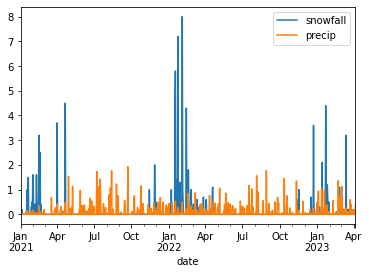

In [121]:
#plots snowfall and precipitation
df_weather[['snowfall','precip']].plot();

In [122]:
#keeps max temp, precipitation, and snowfall columns
df_weather = df_weather[['max temp','precip','snowfall']]

In [123]:
#checks to see only those columns remain
#df_weather.head()

In [124]:
#checks to see where data ends
#df_weather.tail()

In [125]:
#saves weather data to .csv
df_weather.to_csv('data/weather_cleaned.csv')

# Modeling

Looking at my data, I noticed there was both weekly and annual seasonality. Holidays also have a significant impact on sales. Sometimes because of the effects they have consumer behavior, other times because the bakery isn't open! 

I found a time series model created by Facebook called Prophet, which allows for easy incorporation of multiple seasonalities, holidays, and additional regressors. It also has a visual breakdown of how much variability in the overall series can be accounted for by the trend, seasonalities, holidays, and additional regressors.

I ran two models each for retail sales and wholesale sales. The first model included weekly and annual seasonality as well as holidays. For holidays, I used all major U.S. public holidays as well as Ramadan, a Muslim holiday that includes a month of fasting (not great for pita bread sales!). The second model added the Guardians' day home game attendance and Cleveland weather conditions such as maximum temperature, precipitation, and snowfall.

The time series model required two years of training data for annual seasonality purposes, so my train set was January 2021-January 2023 and my test set was January 2023-March 2023. The small test size represents a limitation in my model evaluation.

Ultimately, the first model without regressors performed the best for both retail and wholesale sales. There may have been very slight improvement adding the regressors, but I deemed the additional complexity of the model not worth the minimal improvement. A simpler model that does not require daily weather inputs is also more feasible for real-world model deployment. I can simply give the store manager my complete 2023 forecast, which he can put into action without any additional ongoing work required.

After selecting my model, I re-trained the model with all the data (train and test set) for retail and wholesale sales. I then replaced any negative predictions with zero before adding retail and wholesale sales together for my final forecast of total daily pita bread sales for transactions equal to or below 54 packages of pita. The store manager can add in large orders as they become known.

## Retail First (and Best) Model

In [126]:
#creates new dataframe for Prophet modeling that resets index of daily retail sales
df_daily_prophet = df_daily_na.reset_index()

In [127]:
#looks at first five rows of new df
#df_daily_prophet.head()

In [128]:
#changes column names to be compatible with Prophet model
df_daily_prophet.rename(columns={'index':'ds','pita count':'y'},inplace=True)

In [129]:
#checks that columns were renamed
#df_daily_prophet.head()

In [130]:
#looks at series data info
#df_daily_prophet.info()

In [131]:
#finds 2-year cutoff index
df_daily_prophet.loc[df_daily_prophet['ds'] == '2023-01-12']

ds     y
730 2023-01-12  33.4

In [132]:
#performs train-test split
train_full = df_daily_prophet[:731]
test_full = df_daily_prophet[731:]

In [133]:
#checks to see split was successful
#train_full.tail()

In [134]:
#installs Prophet package
!pip install fbprophet

In [135]:
#imports FB Prophet
import fbprophet

In [136]:
#checks Prophet version
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [137]:
#imports Prophet model
from fbprophet import Prophet

In [138]:
#creates ramadan holiday, adds Ramadan dates for 2021-2023 and sets holiday duration to one month
ramadan = pd.DataFrame({
  'holiday': 'ramadan',
  'ds': pd.to_datetime(['2021-04-12','2022-04-01','2023-03-22']),
  'lower_window': 0,
  'upper_window': 29,
})

In [139]:
#instantiates Prophet model, adds holidays
model = Prophet(holidays=ramadan,changepoint_range=1)
model.add_country_holidays(country_name = 'US')

In [140]:
#fits model
model.fit(train_full)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [141]:
#looks at holidays used
model.train_holiday_names

0                         ramadan
1                  New Year's Day
2       New Year's Day (Observed)
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7     Independence Day (Observed)
8                       Labor Day
9                    Columbus Day
10                   Veterans Day
11                   Thanksgiving
12                  Christmas Day
13       Christmas Day (Observed)
14        Veterans Day (Observed)
dtype: object

In [142]:
#creates dataframe of train dates to be used for train prediction
train_dates = pd.DataFrame(train_full['ds'])
#train_dates

In [143]:
#saves model train predictions to a new variable
train_forecast = model.predict(train_dates)

In [144]:
#prints out model predictions as well as 80% confidence interval
print(train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 2021-01-12   36.886079    9.265683   67.081066
1 2021-01-13   52.763821   26.225514   85.134610
2 2021-01-14   48.506941   20.379313   78.556685
3 2021-01-15   53.043936   26.409095   80.729593
4 2021-01-16  102.582697   73.362185  132.972254


In [145]:
#creates dataframe of dates, actual retail sales and model predictions
train_retail = train_full.merge(train_forecast[['ds','yhat']],on='ds')

In [146]:
#saves dataframe to .csv
train_retail.to_csv('data/train_retail.csv')

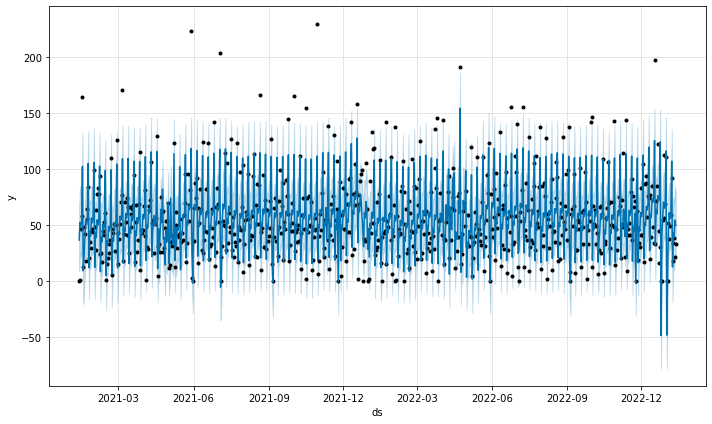

In [147]:
#plots model predictions versus actual sales
model.plot(train_forecast)
plt.show()

#### A couple observations from the components breakdown

You can see that the trend is essentially flat (see the y-axis scale). Most holidays are negative, probably because the bakery is closed. You can also see that Saturday is the busiest day while Sunday is the least busy. Sunday being the low point for the week makes sense as the bakery is open 8am-1pm on Sunday versus 8am-5pm all other days.

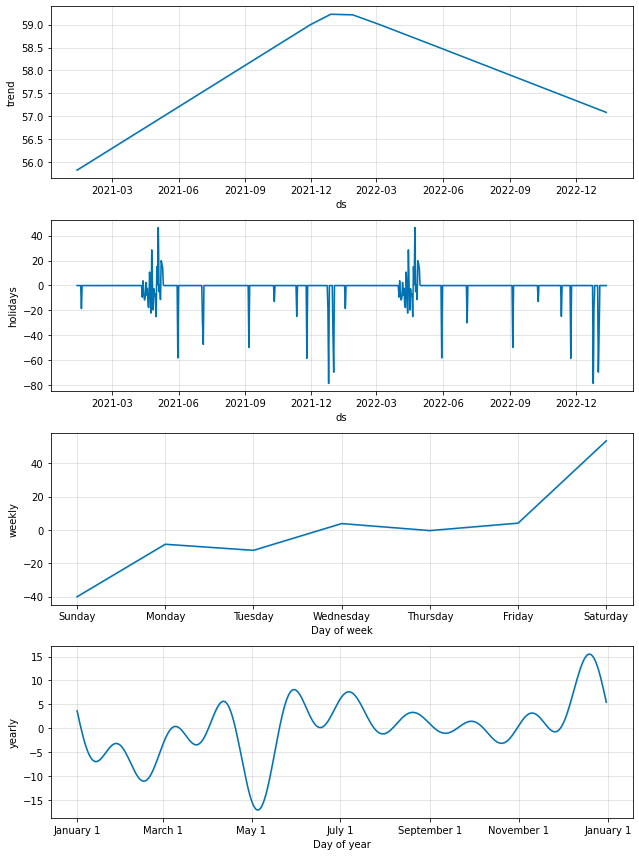

In [148]:
#plots model components
model.plot_components(train_forecast)
plt.show()

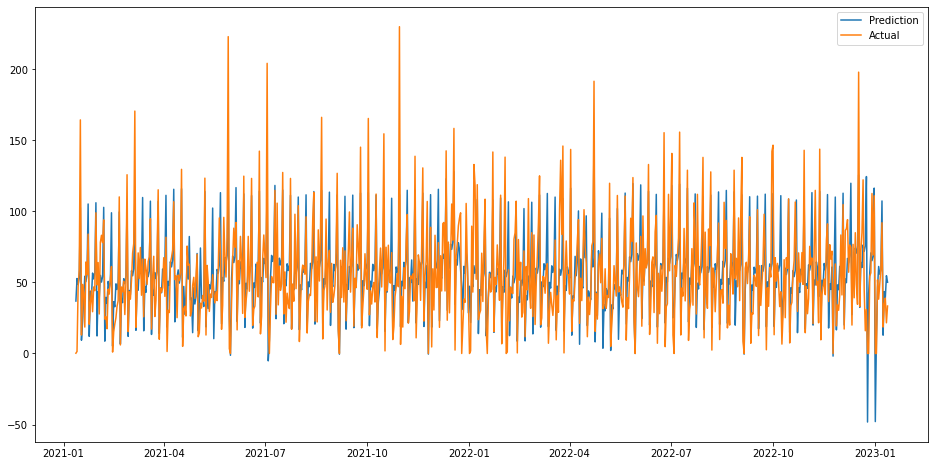

In [149]:
#plots actual versus predictions in line form
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(train_full['ds'],train_forecast['yhat'],label='Prediction')
ax.plot(train_full['ds'],train_full['y'],label='Actual')
ax.legend()
plt.show()

In [150]:
#calculates RMSE for train set
from sklearn.metrics import mean_squared_error
mean_squared_error(train_full['y'],train_forecast['yhat'],squared=False)

22.54121117933477

In [151]:
#creates df for test dates
test_dates = pd.DataFrame(test_full['ds'])

In [152]:
#predicts test set and saves test predictions
test_forecast = model.predict(test_dates)

In [153]:
#prints test predictions as well as 80% confidence interval
print(test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 2023-01-13   54.344984   25.875184   84.847049
1 2023-01-14  103.584724   75.241149  133.485559
2 2023-01-15   10.061598  -19.914293   38.058987
3 2023-01-16   23.184315   -5.433610   52.645881
4 2023-01-17   38.208313    9.420870   66.482129


In [154]:
#creates df of test set actual retail sales and predictions
test_retail = test_full.merge(test_forecast[['ds','yhat']],on='ds')

In [155]:
#saves df to .csv
test_retail.to_csv('data/test_retail.csv')

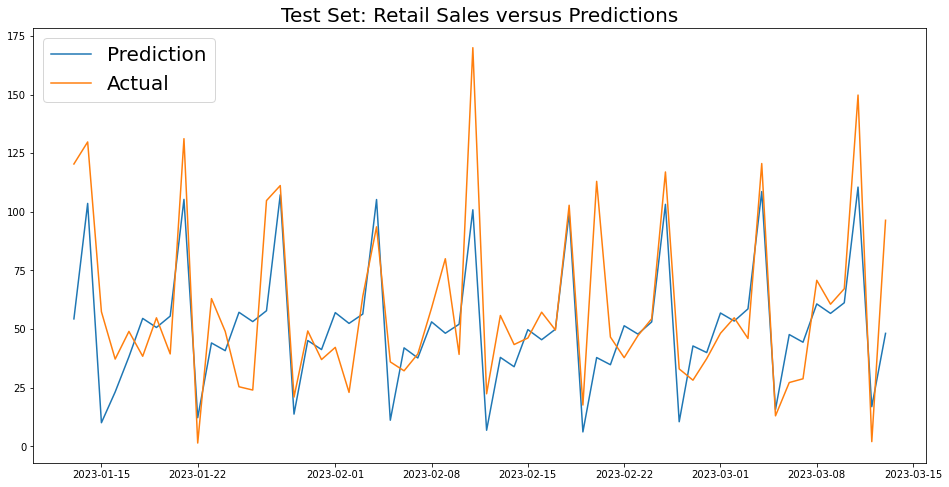

In [156]:
#plots actual versus predicted retail sales for test set
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(test_full['ds'],test_forecast['yhat'],label='Prediction')
ax.plot(test_full['ds'],test_full['y'],label='Actual')
ax.legend(fontsize=20)
ax.set_title('Test Set: Retail Sales versus Predictions',fontsize=20)
plt.savefig('illustrations/retail_sales_vs_predictions_test.jpg',bbox_inches='tight')

In [157]:
#calculates RMSE for test set
mean_squared_error(test_full['y'],test_forecast['yhat'],squared=False)

24.025850254476524

In [158]:
#creates dataframe of 2023 dates
future = model.make_future_dataframe(periods=353)[790:]
#future.head()

In [159]:
#checks that df captures all of 2023
#future.tail()

In [160]:
#instantiates final retail model
final_model = Prophet(holidays=ramadan,changepoint_range=1)
final_model.add_country_holidays(country_name = 'US')

In [161]:
#fits final model
final_model.fit(df_daily_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [162]:
#predicts 2023 retail sales
future_forecast = final_model.predict(future)

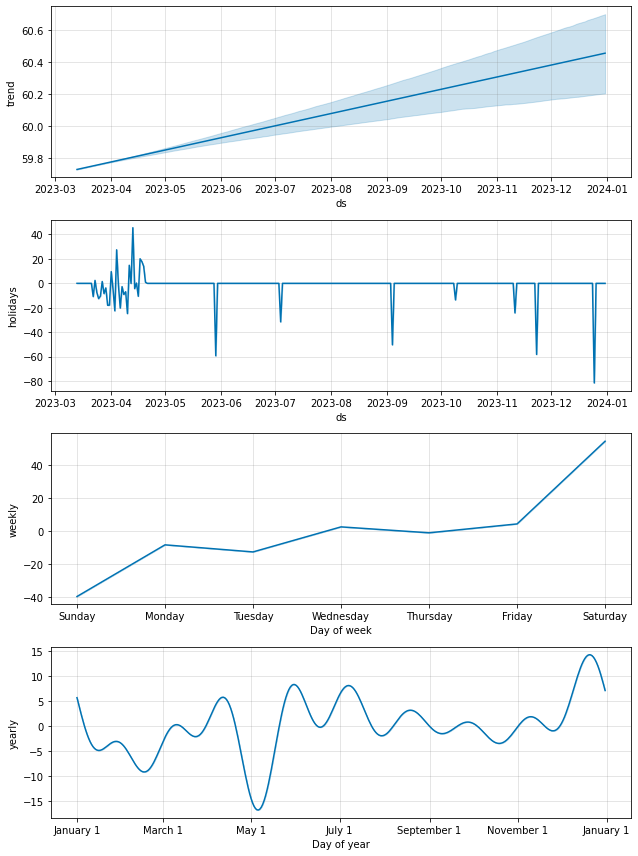

In [163]:
#plots final model components
final_model.plot_components(future_forecast)
plt.show()

In [164]:
#prints forecast predictions and 80% confidence interval
print(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2023-03-13  51.559167   22.729941   79.936898
1 2023-03-14  47.100339   19.496070   75.792115
2 2023-03-15  62.103324   32.277874   91.717069
3 2023-03-16  58.259559   27.642742   84.478155
4 2023-03-17  63.378394   33.653472   93.050320


In [165]:
#saves just dates and forecast predictions to a new df
future_retail = future_forecast[['ds','yhat']]

In [166]:
#saves df to .csv
future_retail.to_csv('data/future_retail.csv')

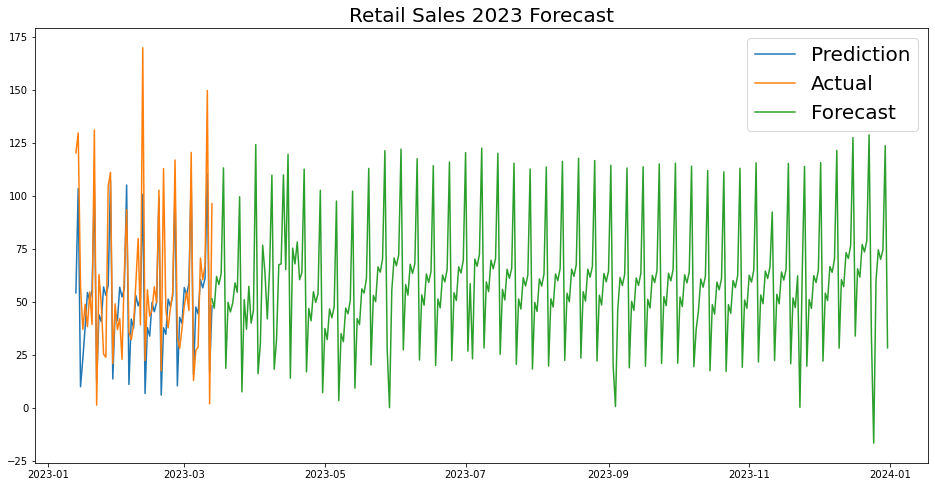

In [167]:
#plots test set actual sales and predictions along with 2023 forecast
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(test_full['ds'],test_forecast['yhat'],label='Prediction')
ax.plot(test_full['ds'],test_full['y'],label='Actual')
ax.plot(future['ds'],future_forecast['yhat'],label='Forecast')
ax.legend(fontsize=20)
ax.set_title('Retail Sales 2023 Forecast',fontsize=20)
plt.savefig('illustrations/retail_sales_forecast.jpg',bbox_inches='tight')

## Retail Model with Additional Regressors

In [168]:
#reads in cleaned weather data
df_weather_cleaned = pd.read_csv('data/weather_cleaned.csv')

In [169]:
#renames unnamed column as date
df_weather_cleaned = df_weather_cleaned.rename({'Unnamed: 0': 'date'},axis=1)

In [170]:
#converts date column to datetime and sets column as index
df_weather_cleaned['date'] = pd.to_datetime(df_weather_cleaned['date'])
df_weather_cleaned.set_index('date',inplace=True)

In [171]:
#reads in cleaned Guardians data
df_games = pd.read_csv('data/guards_games.csv')

In [172]:
#checks out Guardians data
#df_games.head()

In [173]:
#renames unnamed column as date
df_games = df_games.rename({'Unnamed: 0': 'date'},axis=1)

In [174]:
#converts date column to datetime and sets column as index
df_games['date'] = pd.to_datetime(df_games['date'])
df_games.set_index('date',inplace=True)

In [175]:
#concatenates weather and Guardians dataframes together
df_regressors = pd.concat([df_weather_cleaned,df_games],axis=1)

In [176]:
#checks to see concatenation was successful
#df_regressors.head()

In [177]:
#checks to see data goes through 2023
#df_regressors.tail()

In [178]:
#starts regressors df when sales data starts
df_regressors = df_regressors['2021-01-12':]
df_regressors.reset_index(inplace=True)

In [179]:
#prepares date column for Prophet modeling by renaming
df_regressors = df_regressors.rename({'date':'ds'},axis=1)

In [180]:
#checks to see column was renamed
#df_regressors.head()

In [181]:
#merges retail sales df with regressors df
df_modreg = df_daily_prophet.merge(df_regressors,on='ds')

In [182]:
#checks to see that merge was successful
#df_modreg.head()

In [183]:
#checks to see that data ends with last sale date
#df_modreg.tail()

In [184]:
#performs train-test split on data
train_full = df_modreg[:731]
test_full = df_modreg[731:]

In [185]:
#creates df for test dates and regressors for grid search
test_dates = test_full.drop('y',axis=1)

I performed grid searches on the models with additonal regressors but the model improvements were negligible. I commented out the grid search because it took a little while to run.

In [186]:
#creates dictionary of grid search parameters to try
param_grid = {  
'changepoint_prior_scale': [0.005, 0.05, 0.5],
'seasonality_prior_scale': [0.1, 1.0, 10.0],
'holidays_prior_scale': [0.1, 1.0, 10.0],
'n_changepoints': [20,25,30],
'changepoint_range': [1],
'holidays': [ramadan],
}

In [187]:
import itertools

#generates all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
#stores the RMSEs for each params here
rmses = []  

#uses test RMSE to evaluate all parameters
#for params in all_params:
#    model = Prophet(**params,daily_seasonality=False)
#    model.add_country_holidays(country_name = 'US')
#    model.add_regressor('max temp')
#    model.add_regressor('precip')
#    model.add_regressor('snowfall')
#    model.add_regressor('Attendance')
#    model.fit(train_full)  # Fit model with given params
#    test_forecast = model.predict(test_dates)
#    rmse = mean_squared_error(test_full['y'],test_forecast['yhat'],squared=False)
#    rmses.append(rmse)

#finds the best parameters
#tuning_results = pd.DataFrame(all_params)
#tuning_results['rmse'] = rmses
#print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

In [188]:
#instantiates model with additional regressors
model = Prophet(holidays=ramadan,changepoint_range = 1)
model.add_country_holidays(country_name = 'US')
model.add_regressor('max temp')
model.add_regressor('precip')
model.add_regressor('snowfall')
model.add_regressor('Attendance')

In [189]:
#fits model
model.fit(train_full)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [190]:
#creates df that includes dates and regressors for train predictions
train_dates = train_full.drop('y',axis=1)
#train_dates

In [191]:
#predicts train set and saves as new variable
train_forecast = model.predict(train_dates)

In [192]:
#prints train predictions as well as 80% confidence interval
print(train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 2021-01-12   37.169370    8.052029   62.861311
1 2021-01-13   53.929572   23.089310   83.261916
2 2021-01-14   50.579376   21.794200   79.198280
3 2021-01-15   54.306602   26.776976   84.493294
4 2021-01-16  104.472764   74.292896  130.770155


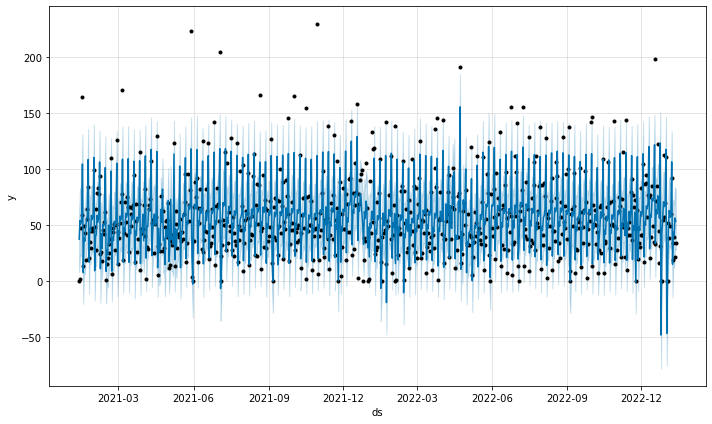

In [193]:
#plots train predictions versus actual retail sales
model.plot(train_forecast)
plt.show()

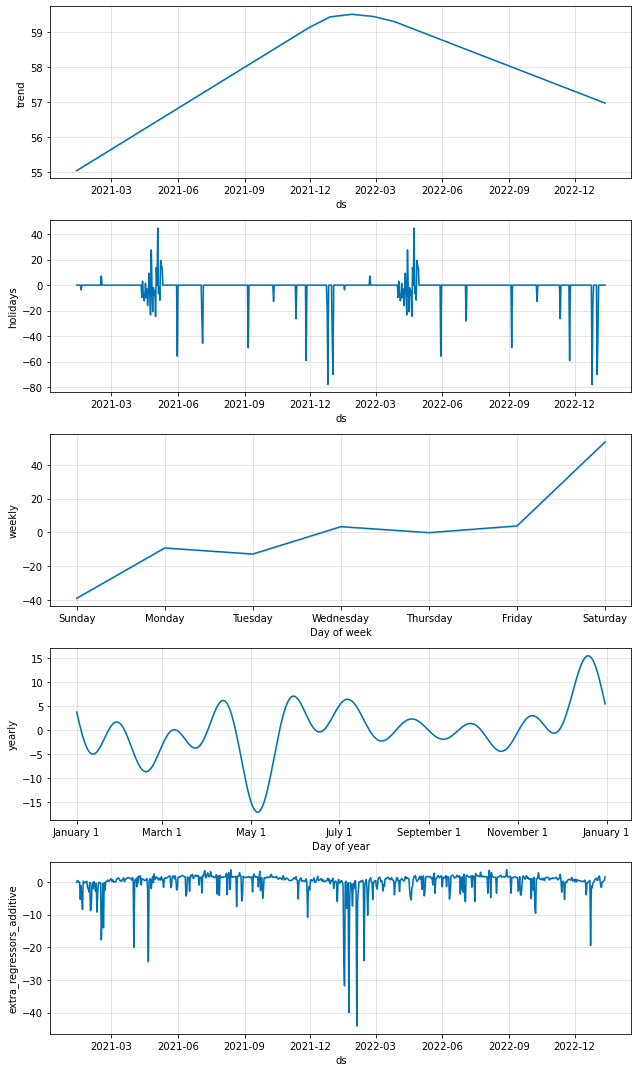

In [194]:
#plots model components, including regressors
model.plot_components(train_forecast)
plt.show()

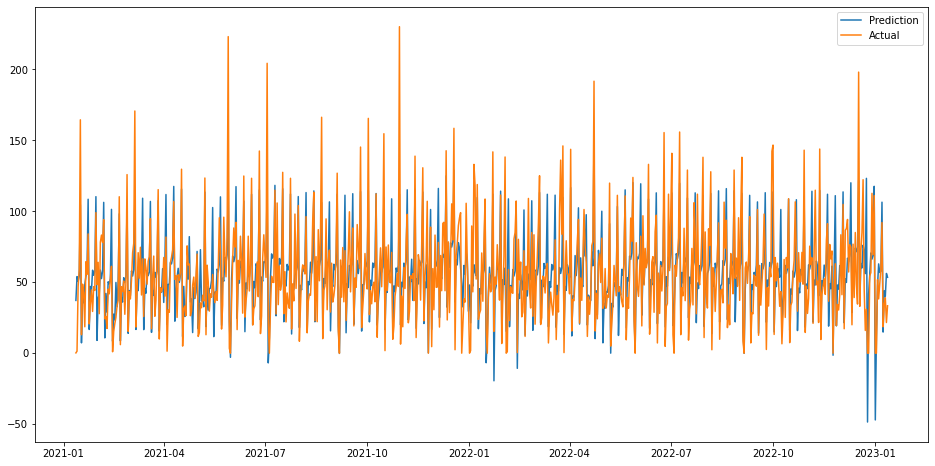

In [195]:
#plots actual retail sales versus predictions in line form
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(train_full['ds'],train_forecast['yhat'],label='Prediction')
ax.plot(train_full['ds'],train_full['y'],label='Actual')
ax.legend()
plt.show()

In [196]:
#calculates train RMSE
mean_squared_error(train_full['y'],train_forecast['yhat'],squared=False)

22.291642574711304

In [197]:
#creates df for test dates and regressors for prediction
test_dates = test_full.drop('y',axis=1)

In [198]:
#predicts test set and saves predictions
test_forecast = model.predict(test_dates)

In [199]:
#prints out test set predictions as well as 80% confidence interval
print(test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds        yhat  yhat_lower  yhat_upper
0 2023-01-13   44.562057   16.000817   71.760765
1 2023-01-14  105.348846   78.114302  133.761753
2 2023-01-15   13.444687  -14.336894   42.297690
3 2023-01-16   40.435176   11.534335   67.182610
4 2023-01-17   41.068455   12.663084   66.284375


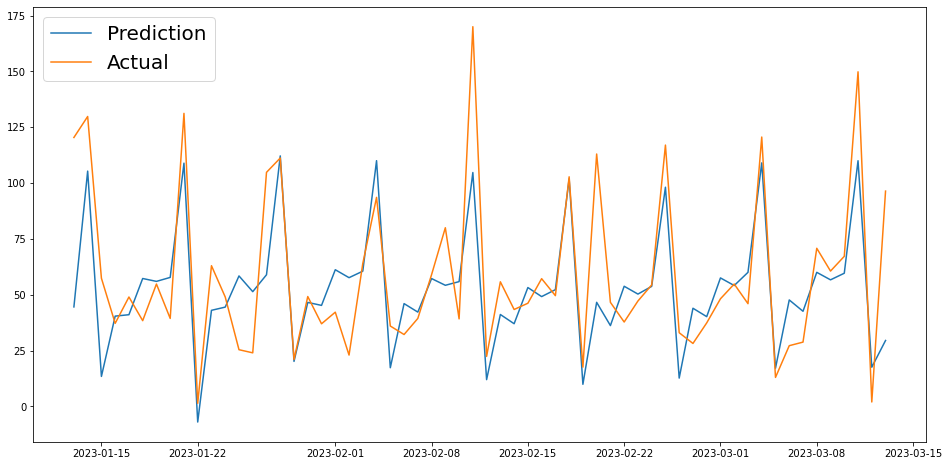

In [200]:
#plots test set actual retail sales versus predictions
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(test_full['ds'],test_forecast['yhat'],label='Prediction')
ax.plot(test_full['ds'],test_full['y'],label='Actual')
ax.legend(fontsize=20)
plt.show()

In [201]:
#calculates test RMSE
mean_squared_error(test_full['y'],test_forecast['yhat'],squared=False)

24.33647200724268

In [202]:
#imports regressor coefficients package
from fbprophet.utilities import regressor_coefficients

A cool feature of FB Prophet is that you can see your regressor coefficients. Running mcmc_samples in the model allows you to see which coefficients are statistically significant via the lower and upper bounds. Unfortunately, that setting was not allowing the model to run on my computer. Yet another reason to use the simpler model, as I cannot be sure these variables are significant.

As it stands, it appears temperature and precipitation are positively correlated with retail sales, while snowfall and guardians day home game attendance are negatively correlated with retail sales. The latter may make sense if non-game-going customers avoid the downtown area due to traffic, while most foot traffic would probably be buying sandwiches (which are less pita-intensive so to speak) rather than packages of pita.

In [203]:
#prints out regressor coefficients
regressor_coefficients(model)

regressor regressor_mode       center  coef_lower      coef  coef_upper
0    max temp       additive    61.414501    0.034086  0.034086    0.034086
1      precip       additive     0.115650    1.091847  1.091847    1.091847
2    snowfall       additive     0.119973   -5.554334 -5.554334   -5.554334
3  Attendance       additive  1289.664843   -0.000293 -0.000293   -0.000293

## Wholesale First (and Best) Model

In [204]:
#creates new dataframe for Prophet modeling that resets index of daily wholesale (ws) sales
df_ws_daily_prophet = df_ws_daily_na.reset_index()

In [205]:
#looks at first five rows of new df
#df_ws_daily_prophet.head()

In [206]:
#changes column names to be compatible with Prophet model
df_ws_daily_prophet.rename(columns={'index':'ds','pita count':'y'},inplace=True)

In [207]:
#checks that columns were renamed
#df_ws_daily_prophet.head()

In [208]:
#looks at series data info
#df_ws_daily_prophet.info()

In [209]:
#finds 2-year cutoff index
df_ws_daily_prophet.loc[df_ws_daily_prophet['ds'] == '2023-01-12']

ds     y
730 2023-01-12  30.0

In [210]:
#performs train-test split
ws_train_full = df_ws_daily_prophet[:731]
ws_test_full = df_ws_daily_prophet[731:]

In [211]:
#checks to see split was successful
#ws_train_full.tail()

In [212]:
#instantiates Prophet model, adds holidays
ws_model = Prophet(holidays=ramadan,changepoint_range=1)
ws_model.add_country_holidays(country_name = 'US')

In [213]:
#fits model on train data
ws_model.fit(ws_train_full)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [214]:
#creates dataframe of train dates to be used for train prediction
ws_train_dates = pd.DataFrame(ws_train_full['ds'])
#ws_train_dates

In [215]:
#saves model train predictions to a new variable
ws_train_forecast = ws_model.predict(train_dates)

In [216]:
#prints out model predictions as well as 80% confidence interval
print(ws_train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2021-01-12  -9.109184  -28.483797   10.592879
1 2021-01-13   9.124055  -11.326400   29.287798
2 2021-01-14   9.601794   -9.825652   30.495942
3 2021-01-15  14.836827   -4.416403   33.213452
4 2021-01-16  -1.113383  -20.230223   18.839067


In [217]:
#creates dataframe of dates, actual ws sales and model predictions
train_wholesale = ws_train_full.merge(ws_train_forecast[['ds','yhat']],on='ds')

In [218]:
#saves dataframe to .csv
train_wholesale.to_csv('data/train_wholesale.csv')

In [219]:
#confirms that ws sales and predictions df was successfully created
#train_wholesale.tail()

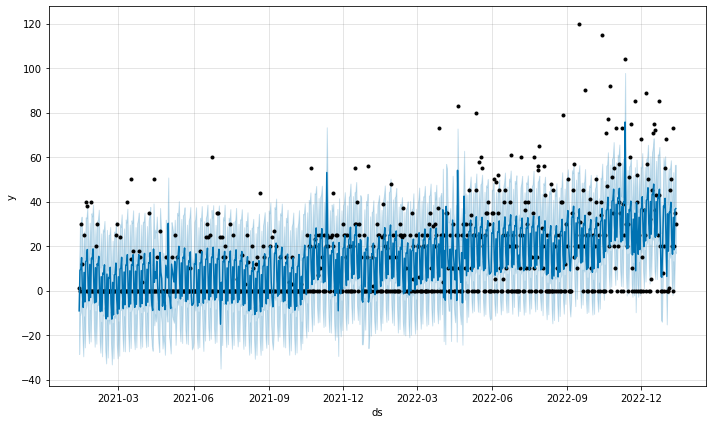

In [220]:
#plots model predictions versus actual sales
ws_model.plot(ws_train_forecast)
plt.show()

#### A couple observations from the ws components breakdown

You can see more of a rising trend over time here as compared with the retail sales. Holidays are a bit more mixed in their effect. The second half of the week seems to be more popular for wholesale sales.

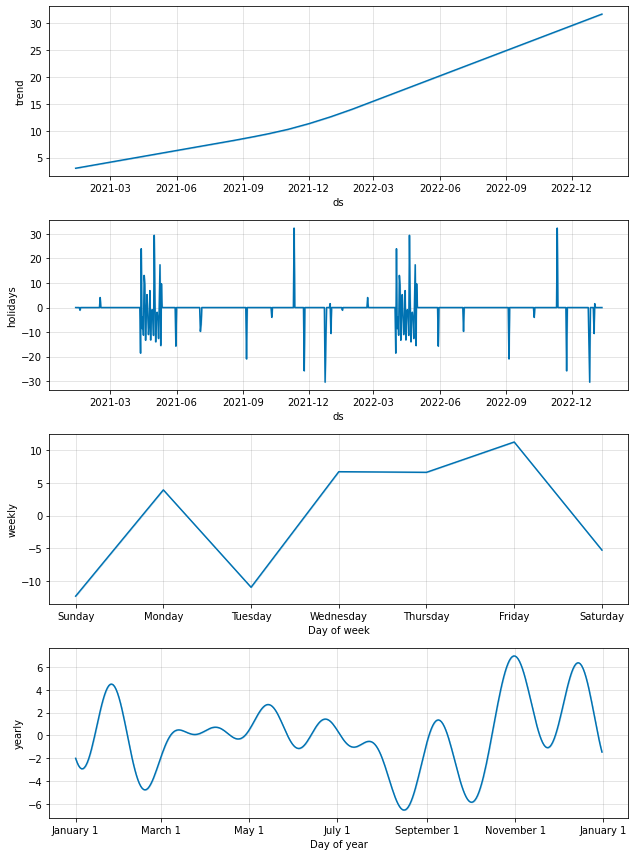

In [221]:
#plots model components
ws_model.plot_components(ws_train_forecast)
plt.show()

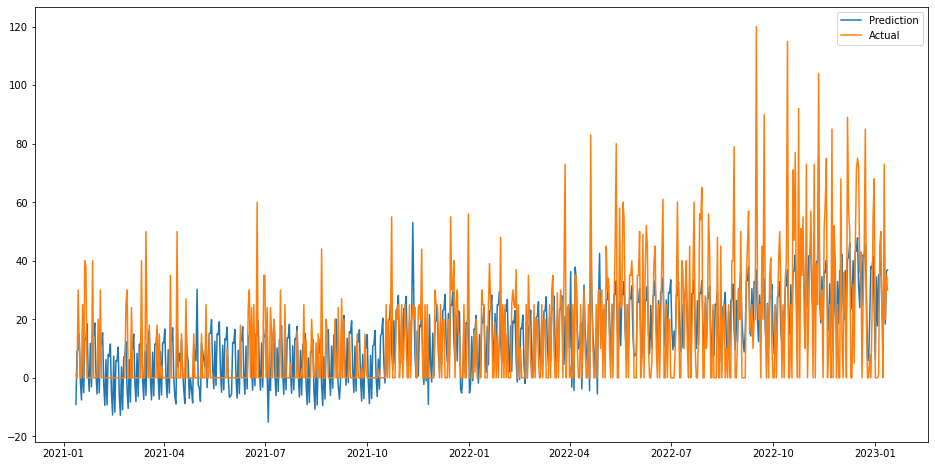

In [222]:
#plots actual versus predictions in line form
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ws_train_full['ds'],ws_train_forecast['yhat'],label='Prediction')
ax.plot(ws_train_full['ds'],ws_train_full['y'],label='Actual')
ax.legend()
plt.show()

In [223]:
#calculates RMSE for train set
mean_squared_error(ws_train_full['y'],ws_train_forecast['yhat'],squared=False)

15.322981447198408

In [224]:
#creates df for test dates
ws_test_dates = pd.DataFrame(ws_test_full['ds'])

In [225]:
#predicts test set and saves test predictions
ws_test_forecast = ws_model.predict(ws_test_dates)

In [226]:
#prints test predictions as well as 80% confidence interval
print(ws_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2023-01-13  42.052362   22.013441   62.754482
1 2023-01-14  26.085002    8.400328   46.613972
2 2023-01-15  19.642269    0.488745   39.429678
3 2023-01-16  35.425090   16.541247   55.849272
4 2023-01-17  22.253840    4.230602   42.108462


In [227]:
#creates df of test set actual retail sales and predictions
test_wholesale = ws_test_full.merge(ws_test_forecast[['ds','yhat']],on='ds')

In [228]:
#saves df to .csv
test_wholesale.to_csv('data/test_wholesale.csv')

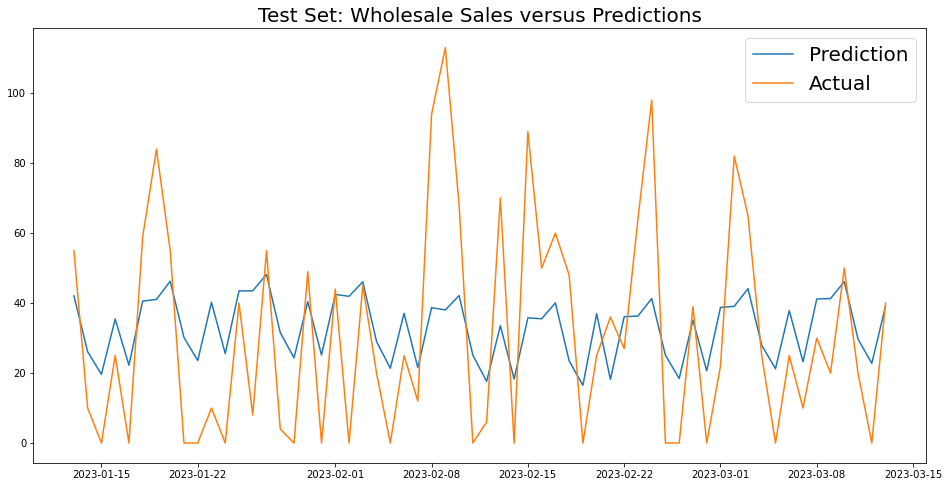

In [229]:
#plots actual versus predicted ws sales for test set
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ws_test_full['ds'],ws_test_forecast['yhat'],label='Prediction')
ax.plot(ws_test_full['ds'],ws_test_full['y'],label='Actual')
ax.legend(fontsize=20)
ax.set_title('Test Set: Wholesale Sales versus Predictions',fontsize=20)
plt.savefig('illustrations/ws_sales_vs_predictions_test.jpg',bbox_inches='tight')

In [230]:
#calculates RMSE for test set
mean_squared_error(ws_test_full['y'],ws_test_forecast['yhat'],squared=False)

25.568404254274853

In [231]:
#creates dataframe of 2023 dates
ws_future = ws_model.make_future_dataframe(periods=353)[790:]
#ws_future.head()

In [232]:
#checks that df captures all of 2023
#ws_future.tail()

In [233]:
#instantiates final ws model
ws_final_model = Prophet(holidays=ramadan,changepoint_range=1)
ws_final_model.add_country_holidays(country_name = 'US')

In [234]:
#fits final model with train and test data
ws_final_model.fit(df_ws_daily_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [235]:
#predicts 2023 ws sales
ws_future_forecast = ws_final_model.predict(ws_future)

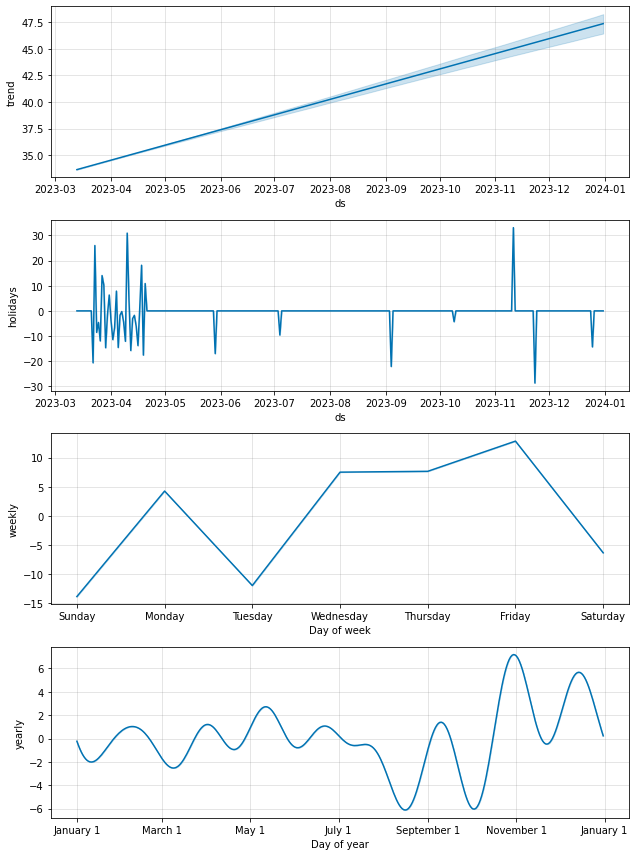

In [236]:
#plots final model components
ws_final_model.plot_components(ws_future_forecast)
plt.show()

In [237]:
#prints forecast predictions and 80% confidence interval
print(ws_future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2023-03-13  35.587616   15.091873   57.379118
1 2023-03-14  19.510643    0.219386   40.022488
2 2023-03-15  39.210965   18.997870   60.019466
3 2023-03-16  39.578918   17.660232   60.243978
4 2023-03-17  45.019039   24.082501   66.846711


In [238]:
#saves just dates and forecast predictions to a new df
future_wholesale = ws_future_forecast[['ds','yhat']]

In [239]:
#saves df to .csv
future_wholesale.to_csv('data/future_wholesale.csv')

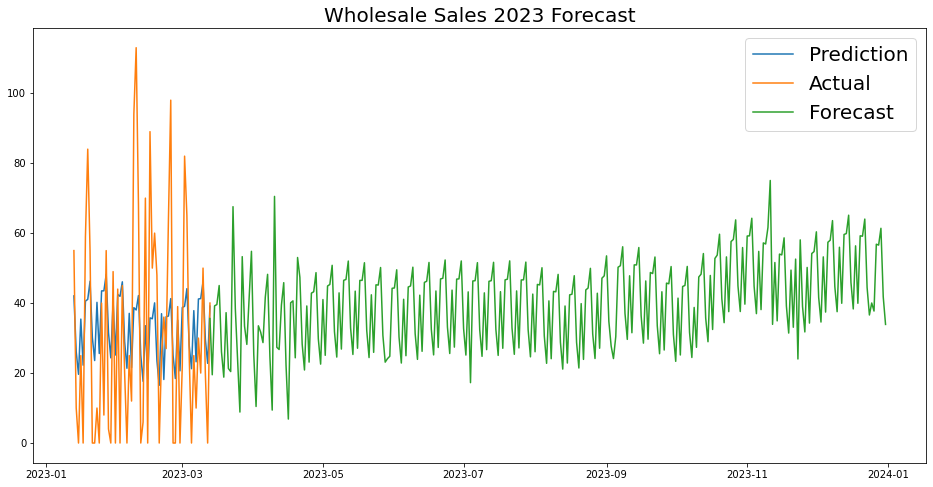

In [240]:
#plots test set actual sales and predictions along with 2023 forecast
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ws_test_full['ds'],ws_test_forecast['yhat'],label='Prediction')
ax.plot(ws_test_full['ds'],ws_test_full['y'],label='Actual')
ax.plot(ws_future['ds'],ws_future_forecast['yhat'],label='Forecast')
ax.legend(fontsize=20)
ax.set_title('Wholesale Sales 2023 Forecast',fontsize=20)
plt.savefig('illustrations/ws_sales_forecast.jpg',bbox_inches='tight')

## Wholesale Model with Additional Regressors

In [241]:
#merges ws sales df with regressors df
df_ws_modreg = df_ws_daily_prophet.merge(df_regressors,on='ds')

In [242]:
#checks to see that merge was successful
#df_ws_modreg.head()

In [243]:
#checks to see that data ends with last sale date
#df_ws_modreg.tail()

In [244]:
#performs train-test split on data
ws_train_full = df_ws_modreg[:731]
ws_test_full = df_ws_modreg[731:]

In [245]:
#creates df for test dates and regressors for grid search
ws_test_dates = ws_test_full.drop('y',axis=1)

In [246]:
import itertools

#generates all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
#stores the RMSEs for each params here
rmses = []  

#uses test RMSE to evaluate all parameters
#for params in all_params:
#    ws_model = Prophet(**params,daily_seasonality=False)
#    ws_model.add_country_holidays(country_name = 'US')
#    ws_model.add_regressor('max temp')
#    ws_model.add_regressor('precip')
#    ws_model.add_regressor('snowfall')
#    ws_model.add_regressor('Attendance')
#    ws_model.fit(ws_train_full)  # Fit model with given params
#    ws_test_forecast = ws_model.predict(ws_test_dates)
#    rmse = mean_squared_error(ws_test_full['y'],ws_test_forecast['yhat'],squared=False)
#    rmses.append(rmse)

#finds the best parameters
#tuning_results = pd.DataFrame(all_params)
#tuning_results['rmse'] = rmses
#print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

In [247]:
#instantiates model with additional regressors
ws_model = Prophet(holidays=ramadan,changepoint_range = 1)
ws_model.add_country_holidays(country_name = 'US')
ws_model.add_regressor('max temp')
ws_model.add_regressor('precip')
ws_model.add_regressor('snowfall')
ws_model.add_regressor('Attendance')

In [248]:
#fits model on train data
ws_model.fit(ws_train_full)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [249]:
#creates df that includes dates and regressors for train predictions
ws_train_dates = ws_train_full.drop('y',axis=1)
#ws_train_dates

In [250]:
#predicts train set and saves as new variable
ws_train_forecast = ws_model.predict(ws_train_dates)

In [251]:
#prints train predictions as well as 80% confidence interval
print(ws_train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2021-01-12  -8.266500  -27.030458   12.350472
1 2021-01-13   9.554951  -10.406046   28.734224
2 2021-01-14  10.023447  -10.337514   29.940797
3 2021-01-15  15.125025   -4.469936   33.676510
4 2021-01-16  -0.866524  -20.826072   19.146038


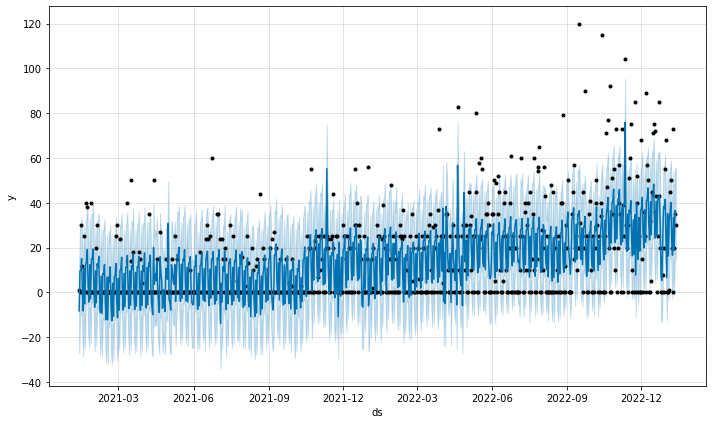

In [252]:
#plots train predictions versus actual ws sales
ws_model.plot(ws_train_forecast)
plt.show()

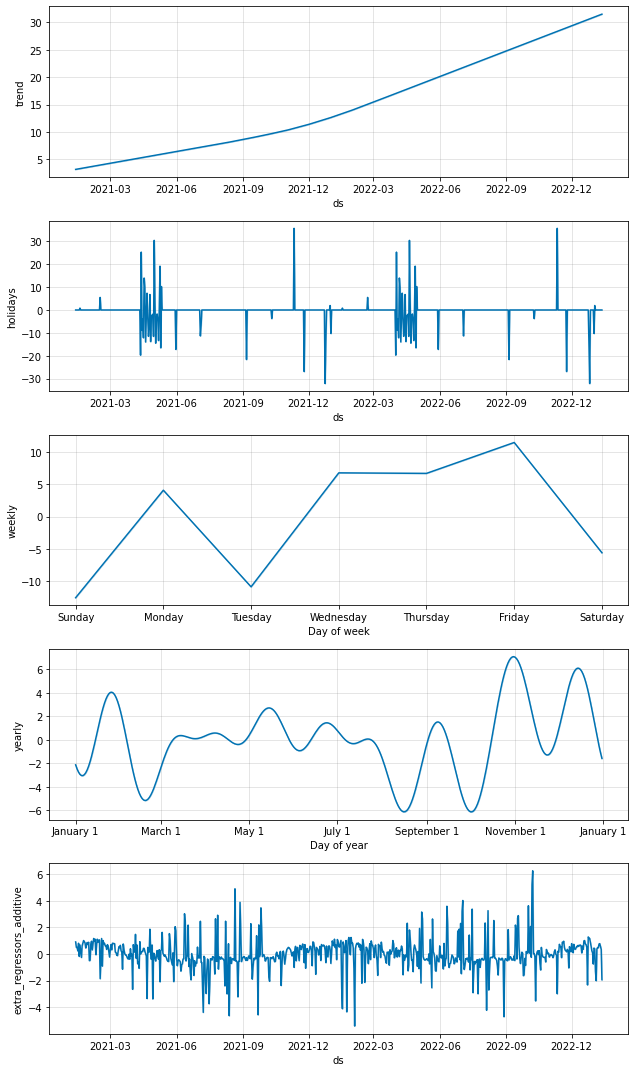

In [253]:
#plots model components, including regressors
ws_model.plot_components(ws_train_forecast)
plt.show()

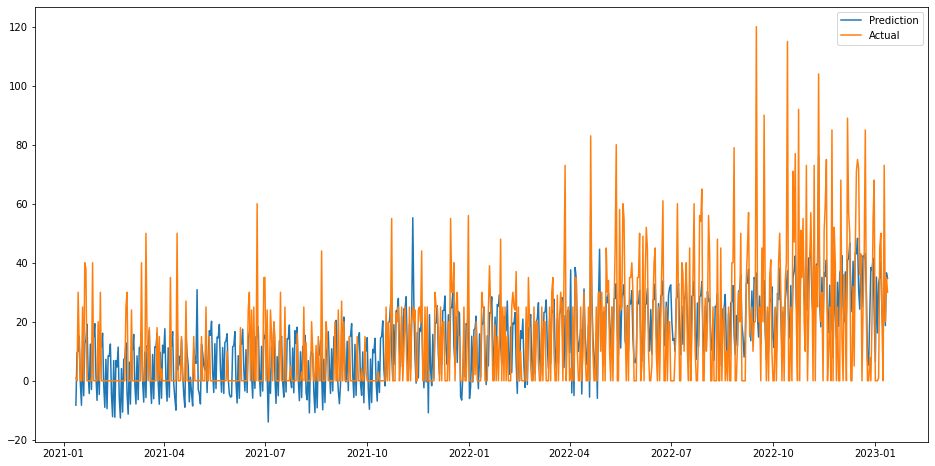

In [254]:
#plots actual ws sales versus predictions in line form
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ws_train_full['ds'],ws_train_forecast['yhat'],label='Prediction')
ax.plot(ws_train_full['ds'],ws_train_full['y'],label='Actual')
ax.legend()
plt.show()

In [255]:
#calculates train RMSE
mean_squared_error(ws_train_full['y'],ws_train_forecast['yhat'],squared=False)

15.288962790330173

In [256]:
#creates df for test dates and regressors for prediction
ws_test_dates = ws_test_full.drop('y',axis=1)

In [257]:
#predicts test set and saves predictions
ws_test_forecast = ws_model.predict(ws_test_dates)

In [258]:
#prints out test set predictions as well as 80% confidence interval
print(ws_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds       yhat  yhat_lower  yhat_upper
0 2023-01-13  40.550138   20.655183   60.735825
1 2023-01-14  26.315588    7.415839   44.874061
2 2023-01-15  19.732088   -0.061186   38.863985
3 2023-01-16  37.090738   18.429420   56.294109
4 2023-01-17  22.091348    3.842755   41.719824


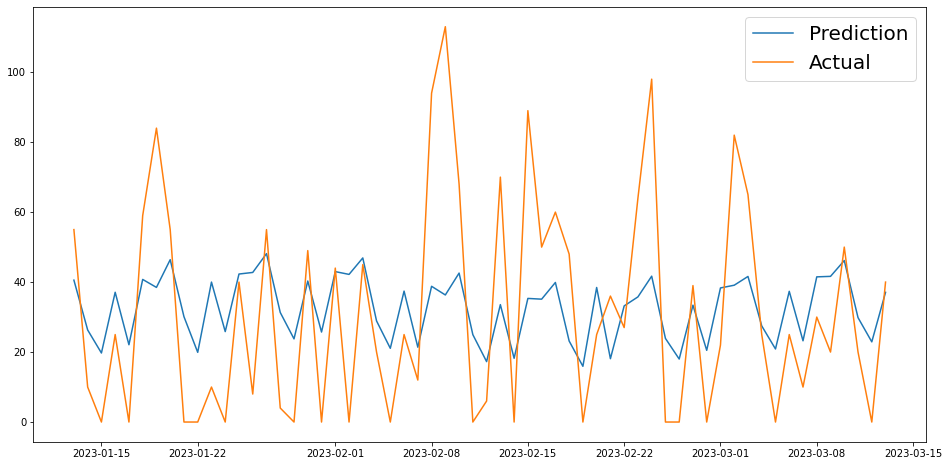

In [259]:
#plots test set actual ws sales versus predictions
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(ws_test_full['ds'],ws_test_forecast['yhat'],label='Prediction')
ax.plot(ws_test_full['ds'],ws_test_full['y'],label='Actual')
ax.legend(fontsize=20)
plt.show()

In [260]:
#calculates test RMSE
mean_squared_error(ws_test_full['y'],ws_test_forecast['yhat'],squared=False)

25.68822370604737

The regressor coefficient signs were different for the wholesale and retail (assuming either are significant). Temperature, precipitation, and snowfall are negatively correlated with wholesale sales while Guardians day home game attendance is positively correlated with wholesale sales.

In [261]:
#prints out regressor coefficients
regressor_coefficients(ws_model)

regressor regressor_mode       center  coef_lower      coef  coef_upper
0    max temp       additive    61.414501   -0.025688 -0.025688   -0.025688
1      precip       additive     0.115650   -2.332099 -2.332099   -2.332099
2    snowfall       additive     0.119973   -0.656241 -0.656241   -0.656241
3  Attendance       additive  1289.664843    0.000170  0.000170    0.000170

# Evaluation

Now that I have determined the best time series model, the real test: is my sales forecast model better than current orders? In order to make that comparison, I attempt to compare apples to apples. Orders are placed five times per week, so I manipulate my daily sales forecast to match the form of the orders. As per the store manager, I assume any order over 54 packages of pita will be known ahead of time, and thus I add in those orders to my model as if I had predicted them with 100% accuracy.

This may be overly generous, as it does not appear that the storefront always orders as if they knew large orders were coming. However, strangely the sales are still made on those days. More digging may be required on this front. Fortunately, it's likely not only one-sided, as there are also likely smaller orders known ahead of time by the store front that my model is forecasting.

Indeed, one data limitation is that I don't know how many/which sales are known ahead of time, which would be useful in determining what I need to model and in comparing my model to current orders. But we can only go off what we know.

A comparison between my model and current orders on the test set showed my model represented a substantial improvement. My model's test RMSE was 42 packages of pita versus 75 packages of pita for current orders.

In [262]:
#reads in daily orders data
df_orders = pd.read_csv('data/orders.csv')

In [263]:
#checks first five rows of orders data
#df_orders.head()

In [264]:
#looks at non-null counts, columns, and data types
#df_orders.info()

In [265]:
#filters order to be only those that are for the store front
df_orders = df_orders.loc[df_orders['Route'] == '9']

In [266]:
#checks that data was filtered
#df_orders.head()

In [267]:
#checks customer IDs, notes that most orders are for the storefront, but a few are for the freezer
#df_orders['Cust ID'].value_counts()

In [268]:
#checks to see that no quantities are returned in orders data
df_orders['Qty Return'].value_counts()

0.0    3980
Name: Qty Return, dtype: int64

In [269]:
#looks at freezer orders, sees that they are for a different bread type and thus not a worry for this pita type
#df_orders.loc[df_orders['Cust ID'] == '01FREE']

In [270]:
#checks that invoice date and delivery date are identical, so it makes no difference which is used
#df_orders.loc[df_orders['Invoice Date'] == df_orders['Delivery Date']]

In [271]:
#checks to see that quantity ordered and quantity delivered are identical so it doesn't matter which is used
#df_orders.loc[df_orders['Qty Order'] == df_orders['Qty Delivery']]

In [272]:
#checks to see if there are multiple customer categories (there are not)
df_orders['Cust Category'].value_counts()

WHSL    3980
Name: Cust Category, dtype: int64

In [273]:
#creates df that only includes columns needed
df_orders = df_orders[['Invoice Date','Item No','Description','Price','Qty Order','Ext Price']]

In [274]:
#checks to see df successfully created
#df_orders.head()

In [275]:
#checks info of df
#df_orders.info()

In [276]:
#filters orders data to only include large plain pita
df_orders = df_orders.loc[df_orders['Item No'] == '101510']

In [277]:
#checks to see filter performed
#df_orders.head()

In [278]:
#checks df info to see number of observations
#df_orders.info()

In [279]:
#converts invoice date to datetime
df_orders['Invoice Date'] = pd.to_datetime(df_orders['Invoice Date'])

In [280]:
#sets invoice date as index
df_orders.set_index('Invoice Date',inplace=True)

In [281]:
#looks at first 10 rows of df
#df_orders.head(10)

In [282]:
#filters data to be only quantity ordered
df_orders = pd.DataFrame(df_orders['Qty Order'])

In [283]:
#renames column to simply be orders
df_orders = df_orders.rename({'Qty Order': 'orders'},axis=1)

In [284]:
#checks first 10 rows of orders df
#df_orders.head(10)

In [285]:
#reads in large white plain sales data (including and excluding large sales)
df_sales = pd.read_csv('data/total_large_white_plain_sales_plus.csv')

df_sales_ex_large = pd.read_csv('data/total_large_white_plain_sales.csv')

In [286]:
#creates new df that will isolate large sales, first by merging two above dfs
df_sales_large = df_sales.merge(df_sales_ex_large,on='date')

In [287]:
#checks to see two df's successfully merged
#df_sales_large.head()

In [288]:
#subtracts sales including large sales from sales excluding large sales to isolate large sales
#creates three new columns
df_sales_large['retail_sales'] = df_sales_large['retail_sales_x'] - df_sales_large['retail_sales_y']
df_sales_large['wholesale_sales'] = df_sales_large['wholesale_sales_x'] - df_sales_large['wholesale_sales_y']
df_sales_large['total_sales'] = df_sales_large['total_sales_x'] - df_sales_large['total_sales_y']

In [289]:
#keeps only newly created columns and date
df_sales_large = df_sales_large[['date','retail_sales','wholesale_sales','total_sales']]

In [290]:
#checks to see large sales df was created
#df_sales_large.head()

In [291]:
#converts date columns for all sales and large sales to datetime and sets date as index
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales.set_index('date',inplace=True)

df_sales_large['date'] = pd.to_datetime(df_sales_large['date'])
df_sales_large.set_index('date',inplace=True)

In [292]:
#checks to see date column is index
#df_sales.head()

In [293]:
#adds numerical day of week column for all sales, large sales, and orders dfs
df_sales['day'] = df_sales.index.dayofweek

df_sales_large['day'] = df_sales_large.index.dayofweek

df_orders['day'] = df_orders.index.dayofweek

In [294]:
#looks at orders data to determine which days of week are missing
#df_orders.head(10)

The bakery bakes Saturday (5) for Saturday & Sunday (5 and 6) and bakes Monday (1) for Monday & Tuesday (1 & 2). The following cells are adding those sales figures for Saturday & Sunday and Monday & Tuesday together so they can be compared with the orders.

In [295]:
#creates new column that is sales shifted back one day
df_sales['quantity shifted'] = df_sales['total_sales'].shift(-1)

df_sales_large['quantity shifted'] = df_sales_large['total_sales'].shift(-1)

In [296]:
#adds sales to quantity shifted back one day (ie adding Sunday to Saturday and Tuesday to Monday)
df_sales['new quantity'] = df_sales['total_sales'] + df_sales['quantity shifted']

df_sales_large['new quantity'] = df_sales_large['total_sales'] + df_sales_large['quantity shifted']

In [297]:
#checks to see columns were created correctly
#df_sales.head(10)

In [298]:
#filters sales to exclude Sunday and Tuesday
df_sales = df_sales.loc[(df_sales['day'] != 1) & (df_sales['day'] != 6)]

df_sales_large = df_sales_large.loc[(df_sales_large['day'] != 1) & (df_sales_large['day'] != 6)]

In [299]:
#defines function that returns the calculated 2-day quantity if Saturday or Monday
#else return the regular 1-day quantity
def bake_days(df):
    if df['day'] == 5 or df['day'] == 0:
        return df['new quantity']
    else:
        return df['total_sales']        

In [300]:
#applies the function to sales and large sales, creates a new column
df_sales['sales'] = df_sales.apply(bake_days,axis=1)

df_sales_large['large_sales'] = df_sales_large.apply(bake_days,axis=1)

In [301]:
#checks to see column was created
#df_sales.head()

In [302]:
#looks at orders data again
#df_orders.head()

In [303]:
#concatenates orders and sales dfs
df_so = pd.concat([df_orders['orders'],df_sales['sales']],axis=1).dropna()

In [304]:
#splits orders and sales into train and test sets for comparison with predicted sales
df_so_train = df_so[:'2023-01-12']

df_so_test = df_so['2023-01-13':]

In [305]:
#checks to see split was successful
#df_so_train.head(15)

In [306]:
#checks to see split was successful
#df_so_train.tail()

In [307]:
#checks to see split was successful
#df_so_test.head()

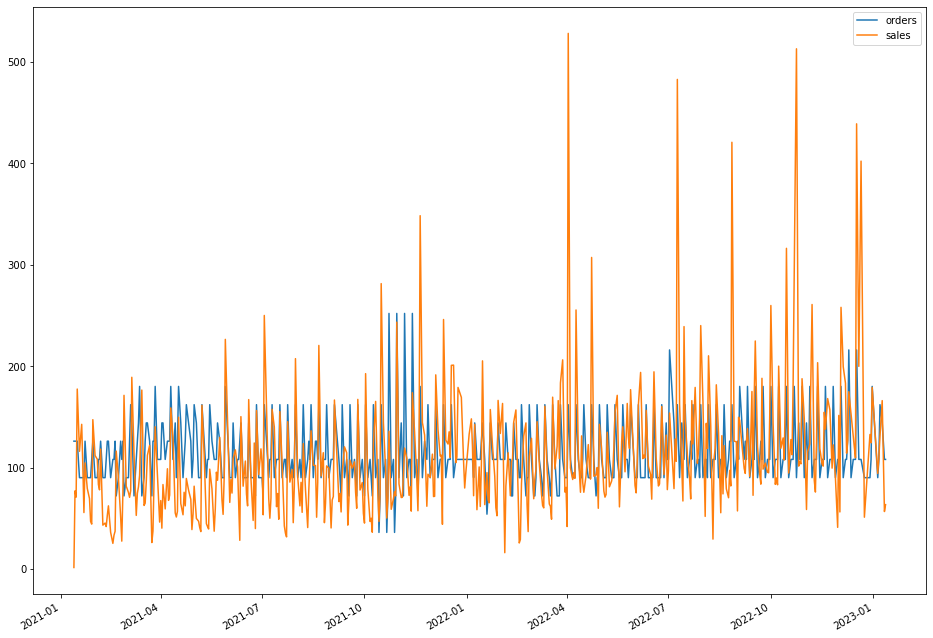

In [308]:
#plots orders versus actual sales for the train set
df_so_train.plot(figsize=(16,12));

In [309]:
#calculates train RMSE for orders
(((df_so_train['orders'] - df_so_train['sales'])**2).mean())**0.5

58.15039429303678

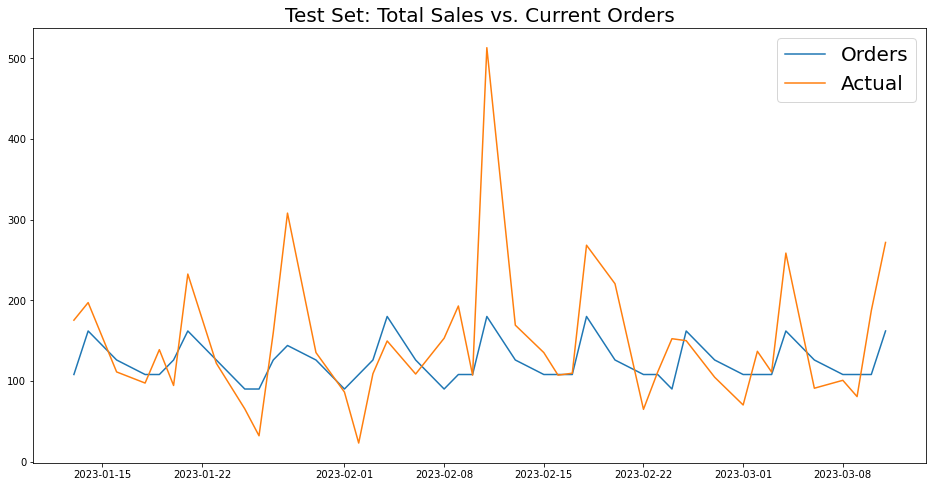

In [310]:
#plots orders versus actual sales for the test set
#df_so_test.plot(figsize=(16,12));

fig,ax = plt.subplots(figsize=(16,8))
ax.plot(df_so_test.index,df_so_test['orders'],label='Orders')
ax.plot(df_so_test.index,df_so_test['sales'],label='Actual')
ax.legend(fontsize=20)
ax.set_title('Test Set: Total Sales vs. Current Orders',fontsize=20)
plt.savefig('illustrations/total_sales_vs_orders.jpg',bbox_inches='tight')

In [311]:
#calculates test RMSE for orders
(((df_so_test['orders'] - df_so_test['sales'])**2).mean())**0.5

74.64591335734588

In [312]:
#reads in train and test wholesale predictions
train_wholesale = pd.read_csv('data/train_wholesale.csv')

test_wholesale = pd.read_csv('data/test_wholesale.csv')

In [313]:
#reads in train and test retail predictions
train_retail = pd.read_csv('data/train_retail.csv')

test_retail = pd.read_csv('data/test_retail.csv')

In [314]:
#looks at train wholesale data
#train_wholesale.head()

In [315]:
#looks at train retail data
#train_retail.head()

In [316]:
#merges retail and wholesale predictions together for train and test sets
train_total = train_retail.merge(train_wholesale,on='ds')

test_total = test_retail.merge(test_wholesale,on='ds')

In [317]:
#checks to see train merge was successful
train_total.head()

Unnamed: 0_x          ds    y_x      yhat_x  Unnamed: 0_y   y_y     yhat_y
0             0  2021-01-12    0.2   36.886079             0   1.0  -9.109184
1             1  2021-01-13    1.4   52.763821             1   0.0   9.124055
2             2  2021-01-14   47.0   48.506941             2  30.0   9.601794
3             3  2021-01-15   58.8   53.043936             3  12.0  14.836827
4             4  2021-01-16  164.4  102.582697             4   0.0  -1.113383

In [318]:
#renames columns
train_total = train_total.drop(['Unnamed: 0_x','Unnamed: 0_y'],axis=1)
train_total = train_total.rename({'y_x':'y_retail','yhat_x':'yhat_retail','y_y':'y_wholesale','yhat_y':'yhat_wholesale'},axis=1)

test_total = test_total.drop(['Unnamed: 0_x','Unnamed: 0_y'],axis=1)
test_total = test_total.rename({'y_x':'y_retail','yhat_x':'yhat_retail','y_y':'y_wholesale','yhat_y':'yhat_wholesale'},axis=1)

In [319]:
#checks to see columns were renamed
#train_total.head()

In [320]:
#looks to see if any train retail predictions were negative
#train_total[train_total['yhat_retail'] < 0]

In [321]:
#sets any negative predictions to zero for train and test set
train_total['yhat_retail'] = np.where(train_total['yhat_retail'] < 0,0,train_total['yhat_retail'])
train_total['yhat_wholesale'] = np.where(train_total['yhat_wholesale'] < 0,0,train_total['yhat_wholesale'])

test_total['yhat_retail'] = np.where(test_total['yhat_retail'] < 0,0,test_total['yhat_retail'])
test_total['yhat_wholesale'] = np.where(test_total['yhat_wholesale'] < 0,0,test_total['yhat_wholesale'])

In [322]:
#creates new columns of total actual and predicted sales for train and test set
train_total['y_total'] = train_total['y_retail'] + train_total['y_wholesale']
train_total['yhat_total'] = train_total['yhat_retail'] + train_total['yhat_wholesale']

test_total['y_total'] = test_total['y_retail'] + test_total['y_wholesale']
test_total['yhat_total'] = test_total['yhat_retail'] + test_total['yhat_wholesale']

In [323]:
#checks to see new columns were created in train set
#train_total.head()

In [324]:
#converts ds column to datetime and sets as index
train_total['ds'] = pd.to_datetime(train_total['ds'])
train_total.set_index('ds',inplace=True)

test_total['ds'] = pd.to_datetime(test_total['ds'])
test_total.set_index('ds',inplace=True)

In [325]:
#creates new numerical column for day of the week
train_total['day'] = train_total.index.dayofweek

test_total['day'] = test_total.index.dayofweek

In [326]:
#creates new column that shifts predicted sales back 1 day
train_total['quantity shifted'] = train_total['yhat_total'].shift(-1)

test_total['quantity shifted'] = test_total['yhat_total'].shift(-1)

In [327]:
#creates new column that adds predicted sales to 1-day shifted back sales
train_total['new quantity'] = train_total['yhat_total'] + train_total['quantity shifted']

test_total['new quantity'] = test_total['yhat_total'] + test_total['quantity shifted']

In [328]:
#filters data to exclude Sunday and Tuesday
train_total = train_total.loc[(train_total['day'] != 1) & (train_total['day'] != 6)]

test_total = test_total.loc[(test_total['day'] != 1) & (test_total['day'] != 6)]

In [329]:
#recalls function that
#returns the calculated 2-day quantity if Saturday or Monday
#else return the regular 1-day quantity
def bake_days(df):
    if df['day'] == 5 or df['day'] == 0:
        return df['new quantity']
    else:
        return df['yhat_total']

In [330]:
#applies function to create new column of predicted sales that matches orders format
train_total['predicted_sales'] = train_total.apply(bake_days,axis=1)

test_total['predicted_sales'] = test_total.apply(bake_days,axis=1)

In [331]:
#checks to see new column successfully created
#train_total.head(15)

In [332]:
#merges predicted sales and actual sales dfs
train_total = train_total.merge(df_sales['sales'],left_index=True,right_index=True)

test_total = test_total.merge(df_sales['sales'],left_index=True,right_index=True)

In [333]:
#adds large sales to df
train_total = train_total.merge(df_sales_large['large_sales'],left_index=True,right_index=True)

test_total = test_total.merge(df_sales_large['large_sales'],left_index=True,right_index=True)

In [334]:
#checks to see columns all added to train df
#train_total.head()

In [335]:
#checks to see columns all added to test df
#test_total.head()

In [336]:
#checks to see columns all added to train df
#train_total.tail()

In [337]:
#checks to see columns all added to test df
#test_total.tail()

In [338]:
#adds large sales to predicted sales (assumes large sales predicted at 100% accuracy)
train_total['all_predicted_sales'] = train_total['predicted_sales'] + train_total['large_sales']

test_total['all_predicted_sales'] = test_total['predicted_sales'] + test_total['large_sales']

In [339]:
#calculates train RMSE for predicted sales
(((train_total['all_predicted_sales'] - train_total['sales'])**2).mean())**0.5

32.895576732343144

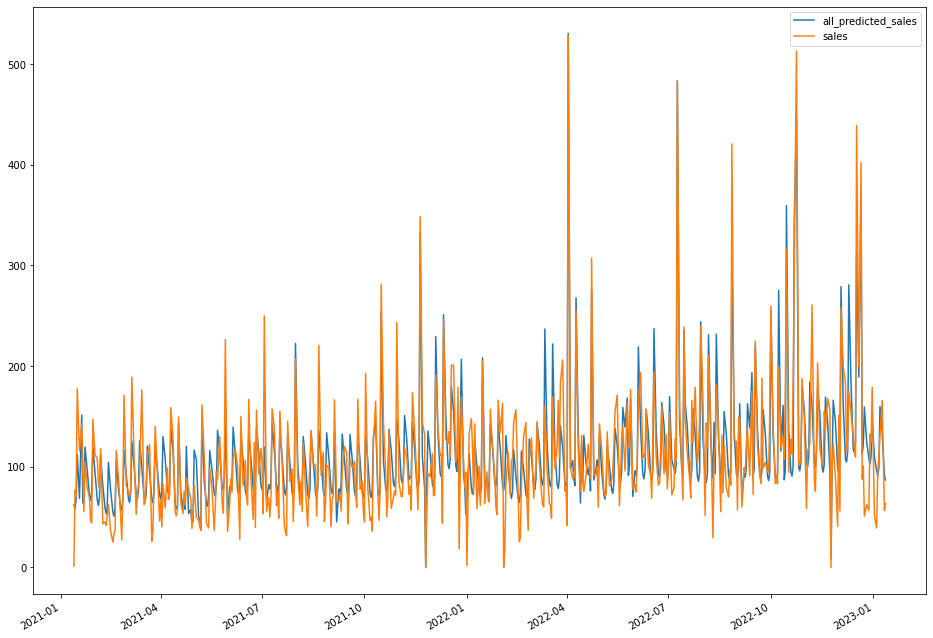

In [340]:
#plots predicted sales versus actual sales for train set
train_total[['all_predicted_sales','sales']].plot(figsize=(16,12));

In [341]:
#calculates test RMSE for predicted sales
(((test_total['all_predicted_sales'] - test_total['sales'])**2).mean())**0.5

42.108682000843196

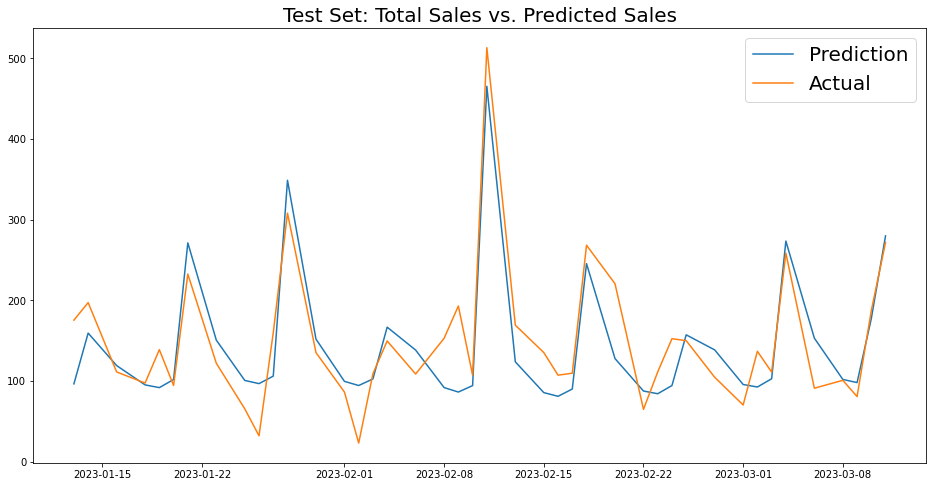

In [342]:
#plots predicted sales versus actual sales for test set
#test_total[['all_predicted_sales','sales']].plot(figsize=(16,12));

fig,ax = plt.subplots(figsize=(16,8))
ax.plot(test_total.index,test_total['all_predicted_sales'],label='Prediction')
ax.plot(test_total.index,test_total['sales'],label='Actual')
ax.legend(fontsize=20)
ax.set_title('Test Set: Total Sales vs. Predicted Sales',fontsize=20)
plt.savefig('illustrations/total_sales_vs_predicted_sales.jpg',bbox_inches='tight')

# Recommendations

My model prediction represents a data-driven improvement over current orders and can be deployed immediately for the rest of 2023. Large sales for both retail and wholesale can be added in as they become known.

In [343]:
#reads in 2023 retail and wholesale forecasts
future_retail = pd.read_csv('data/future_retail.csv')

future_wholesale = pd.read_csv('data/future_wholesale.csv')

In [344]:
#looks at retail forecast
#future_retail.head()

In [345]:
#looks at wholesale forecast
#future_wholesale.head()

In [346]:
#drops unnamed column
future_retail = future_retail.drop('Unnamed: 0',axis=1)

future_wholesale = future_wholesale.drop('Unnamed: 0',axis=1)

In [347]:
#renames columns
future_retail = future_retail.rename({'ds':'date','yhat':'retail_pred'},axis=1)

future_wholesale = future_wholesale.rename({'ds':'date','yhat':'wholesale_pred'},axis=1)

In [348]:
#converts date column to datetime and sets as index
future_retail['date'] = pd.to_datetime(future_retail['date'])
future_retail.set_index('date',inplace=True)

future_wholesale['date'] = pd.to_datetime(future_wholesale['date'])
future_wholesale.set_index('date',inplace=True)

In [349]:
#merges retail and wholesale forecast dfs together
future_forecast = future_retail.merge(future_wholesale,left_index=True,right_index=True)

In [350]:
#determine that one retail prediction is negative (and zero wholesale predictions)
future_forecast[future_forecast['retail_pred']<0]

retail_pred  wholesale_pred
date                                   
2023-12-25   -16.488986       40.024101

In [351]:
#sets negative retail prediction equal to zero
future_forecast['retail_pred'] = np.where(future_forecast['retail_pred']<0,0,future_forecast['retail_pred'])

In [352]:
#creates new column that adds retail and wholesale predictions together
future_forecast['total_pred'] = future_forecast['retail_pred'] + future_forecast['wholesale_pred']

In [353]:
#rounds total sales prediction to nearest whole number
future_forecast = future_forecast.round()

In [354]:
#looks at head of forecast
#future_forecast.head()

In [355]:
#looks at tail of forecast
#future_forecast.tail()

In [356]:
#saves 2023 forecast to .csv
future_forecast.to_csv('data/future_forecast.csv')

# Future Insights

This model is ready to go and can help right now, but what can be done in the future to continue helping the bakery and improving this model? First, we can expand the model to other bread types. It is likely that my model can improve ordering for other bread types as well. Second, we can keep tracking our model’s performance for a larger test set (both the simple and advanced models). We can also periodically retrain the model as we get more data. Lastly, we can look into determining whether over-ordering (selling discounted bread and discarding old bread) or under-ordering (missing out on potential sales) is more costly for the business. This can inform how we assess the model's performance.

I am proud to be able to help the business my grandfather started over 50 years ago using tools I learned a few months ago. Hopefully the first project of many!